# Preparing extra articles 📰

In [4]:
path_to_root = '/work/PernilleHøjlundBrams#8577/NLP_2023_P'


In [8]:
# Make root path
path_to_root = '/work/PernilleHøjlundBrams#8577/NLP_2023_P'

# Get data in
import pandas as pd
#extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles.csv", sep = ",").drop(columns = ["Unnamed: 0"])
# NOTE: doing it with some more - 23rd dec
extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# Take a look
extra_articles

,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url
0,"december 17, 2023",Pranshu Verma,The Washington Post,The rise of AI fake news is creating a ‘misinf...,AI is making it easy for anyone to create prop...,Artificial intelligence is automating the crea...,https://www.washingtonpost.com/technology/2023...
1,"May 30, 2023",Matt O'Brien,AP News,Artificial intelligence raises risk of extinct...,NaN,"Scientists and tech industry leaders, includin...",https://apnews.com/article/artificial-intellig...
2,"december 14, 2023",Nicole Winfield,AP News,"Pope, once a victim of AI-generated imagery, c...",NaN,ROME (AP) — Pope Francis on Thursday called fo...,https://apnews.com/article/vatican-pope-ai-art...
3,"december 14, 2023",Matt O'Brien,AP News,2023: The year we played with artificial intel...,NaN,Artificial intelligence went mainstream in 202...,https://apnews.com/article/ai-2023-artificial-...
4,"october 25, 2023",Matt O'Brien and Haleluya Hadero,AP News,AI-generated child sexual abuse images could f...,NaN,NEW YORK (AP) — The already-alarming prolifera...,https://apnews.com/article/ai-artificial-intel...
...,...,...,...,...,...,...,...
92,"March 9, 2021",Sharona Hoffman,The conversation,Biased AI can be bad for your health – here’s ...,NaN,Artificial intelligence holds great promise fo...,https://theconversation.com/biased-ai-can-be-b...
93,"february 14, 2020",Michele Gilman,The conversation,AI algorithms intended to root out welfare fra...,NaN,President Donald Trump recently suggested ther...,https://theconversation.com/ai-algorithms-inte...
94,"march 16, 2023",Ashley M. Hopkins,The conversation,We asked ChatGPT and Dr Google the same questi...,NaN,"You may have heard the buzz about ChatGPT, a t...",https://theconversation.com/we-asked-chatgpt-a...
95,"march 5, 2023",Jordan Richard Schoenherr,The conversation,Generative AI like ChatGPT reveal deep-seated ...,NaN,ChatGPT has cast long shadows over the media a...,https://theconversation.com/generative-ai-like...


### Sentiment analysis on the extra articles to gauge if it helped a bit

In [9]:
# -------- Get polarity/subjectivity scores
from sklearn.preprocessing import StandardScaler
import pandas as pd
from textblob import TextBlob

# Function to calculate sentiment and subjectivity
def analyze_sentiment_and_subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Apply the function to each article
extra_articles[['Polarity', 'Subjectivity']] = extra_articles['Article Body'].apply(
    lambda x: pd.Series(analyze_sentiment_and_subjectivity(x))
)



# -------- Get ABSA and roberta sentiment label
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# LOAD 1: (Aspect-Based Sentiment Analysis = ABSA) # 0 to 1, indicating level of confidence for each sentiment
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# LOAD 2: a traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path,
                          tokenizer=sentiment_model_path)

# ----- Get scores on for aspects
import torch
from torch.nn.functional import softmax

# Assuming absa_model and absa_tokenizer are defined and loaded

def run_absa_for_dataframe(df, aspects):
    for aspect in aspects:
        # Check if the columns already exist
        if not all(x in df.columns for x in [f'{aspect}_POS', f'{aspect}_NEU', f'{aspect}_NEG']):
            # Create a column for each aspect and sentiment if not exist
            df[f'{aspect}_POS'] = 0.0
            df[f'{aspect}_NEU'] = 0.0
            df[f'{aspect}_NEG'] = 0.0
            
            for idx, sentence in enumerate(df['Article Body']):
                # Tokenize and predict sentiment
                inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                with torch.no_grad():  # Disable gradient calculation
                    outputs = absa_model(**inputs)

                # Calculate probabilities
                probs = softmax(outputs.logits, dim=1).numpy()[0]

                # Assign the probabilities to the correct columns
                df.loc[idx, f'{aspect}_NEG'] = probs[0]
                df.loc[idx, f'{aspect}_NEU'] = probs[1]
                df.loc[idx, f'{aspect}_POS'] = probs[2]
        else:
            print(f"Columns for aspect '{aspect}' already exist. Skipping ABSA for this aspect.")

    return df


# Use
aspects = ['AI']#,
        #    'autonomous',
        #    'health',
        #    'ethics',
        #    'privacy',
        #    'future',
        #   'safety',]
        #    'robots',
        #    'data']
           
extra_articles = run_absa_for_dataframe(extra_articles, aspects)
print("Done with ABSA.")


#df.to_csv(f"{path_to_root}/data/prelim_dataframes/df_w_absa_full.csv")

/work/PernilleHøjlundBrams#8577/venvs_new_exam/nlp-e23-exam_new/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Done with ABSA.


/tmp/ipykernel_481473/362952980.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_481473/362952980.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_481473/362952980.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


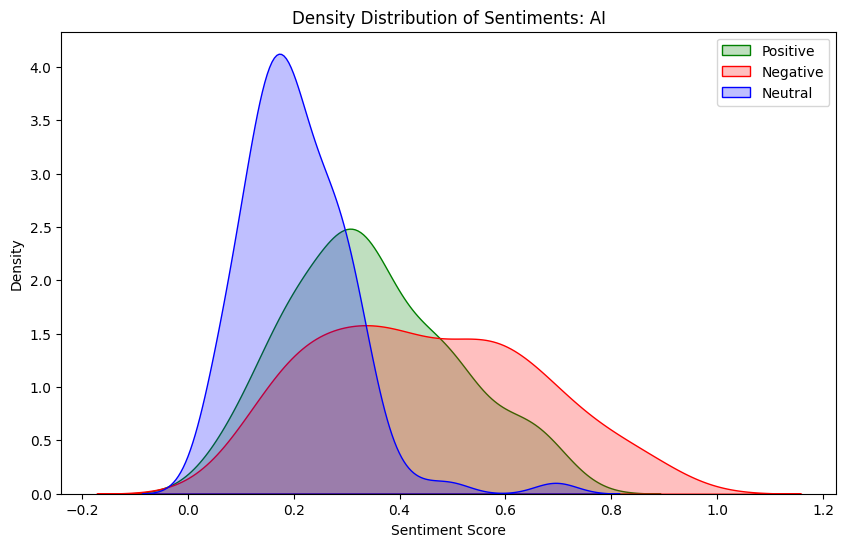

In [10]:
# Plot

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pos_list, neg_list, and neu_list are already defined
# For example:
# pos_list = [0.1, 0.2, 0.3, ...]
# neg_list = [0.2, 0.1, 0.05, ...]
# neu_list = [0.7, 0.6, 0.65, ...]

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = extra_articles[f'{aspect}_POS'],
                               neg_list = extra_articles[f'{aspect}_NEG'],
                               neu_list = extra_articles[f'{aspect}_NEU'])  

In [11]:
# ---- GET CATEGORIES
import pandas as pd

# Copy df
df_test = extra_articles.copy()

# Revised Intervals
# Extreme Negative: [-1, -0.6)
# Somewhat Negative: [-0.6, -0.2)
# Neutral: [-0.2, 0.2)
# Somewhat Positive: [0.2, 0.6)
# Extreme Positive: [0.6, 1]

def categorize_polarity(score):
    if score < -0.6:
        return 'Extreme Negative'
    elif score < -0.2:
        return 'Somewhat Negative'
    elif score < 0.2:
        return 'Neutral'
    elif score < 0.6:
        return 'Somewhat Positive'
    else:
        return 'Extreme Positive'

def categorize_subjectivity(score):
    if score < 0.33:
        return 'Objective'
    elif score < 0.66:
        return 'Somewhat Subjective'
    else:
        return 'Highly Subjective'

# Apply the function to your DataFrame
df_test['Polarity Category'] = df_test['Polarity'].apply(categorize_polarity)
df_test['Subjectivity Category'] = df_test['Subjectivity'].apply(categorize_subjectivity)

df_test


,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url,Polarity,Subjectivity,AI_POS,AI_NEU,AI_NEG,Polarity Category,Subjectivity Category
0,"december 17, 2023",Pranshu Verma,The Washington Post,The rise of AI fake news is creating a ‘misinf...,AI is making it easy for anyone to create prop...,Artificial intelligence is automating the crea...,https://www.washingtonpost.com/technology/2023...,0.044660,0.473436,0.322779,0.206170,0.471051,Neutral,Somewhat Subjective
1,"May 30, 2023",Matt O'Brien,AP News,Artificial intelligence raises risk of extinct...,NaN,"Scientists and tech industry leaders, includin...",https://apnews.com/article/artificial-intellig...,0.089084,0.455128,0.324569,0.324077,0.351353,Neutral,Somewhat Subjective
2,"december 14, 2023",Nicole Winfield,AP News,"Pope, once a victim of AI-generated imagery, c...",NaN,ROME (AP) — Pope Francis on Thursday called fo...,https://apnews.com/article/vatican-pope-ai-art...,0.028099,0.435061,0.467939,0.294264,0.237797,Neutral,Somewhat Subjective
3,"december 14, 2023",Matt O'Brien,AP News,2023: The year we played with artificial intel...,NaN,Artificial intelligence went mainstream in 202...,https://apnews.com/article/ai-2023-artificial-...,0.111853,0.506686,0.286163,0.140989,0.572848,Neutral,Somewhat Subjective
4,"october 25, 2023",Matt O'Brien and Haleluya Hadero,AP News,AI-generated child sexual abuse images could f...,NaN,NEW YORK (AP) — The already-alarming prolifera...,https://apnews.com/article/ai-artificial-intel...,0.101039,0.540597,0.325153,0.128224,0.546623,Neutral,Somewhat Subjective
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"March 9, 2021",Sharona Hoffman,The conversation,Biased AI can be bad for your health – here’s ...,NaN,Artificial intelligence holds great promise fo...,https://theconversation.com/biased-ai-can-be-b...,0.094630,0.476450,0.214857,0.117002,0.668141,Neutral,Somewhat Subjective
93,"february 14, 2020",Michele Gilman,The conversation,AI algorithms intended to root out welfare fra...,NaN,President Donald Trump recently suggested ther...,https://theconversation.com/ai-algorithms-inte...,0.012950,0.448182,0.201850,0.126729,0.671420,Neutral,Somewhat Subjective
94,"march 16, 2023",Ashley M. Hopkins,The conversation,We asked ChatGPT and Dr Google the same questi...,NaN,"You may have heard the buzz about ChatGPT, a t...",https://theconversation.com/we-asked-chatgpt-a...,0.077810,0.469568,0.402393,0.096331,0.501276,Neutral,Somewhat Subjective
95,"march 5, 2023",Jordan Richard Schoenherr,The conversation,Generative AI like ChatGPT reveal deep-seated ...,NaN,ChatGPT has cast long shadows over the media a...,https://theconversation.com/generative-ai-like...,0.066848,0.451615,0.091764,0.060656,0.847580,Neutral,Somewhat Subjective


Polarity Category
Neutral              96
Somewhat Positive     1
Name: count, dtype: int64


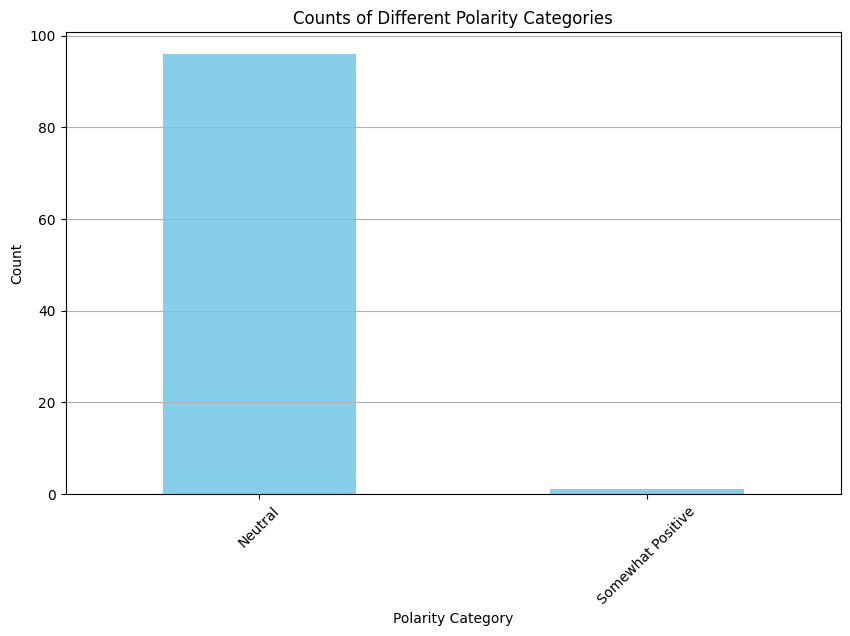

Subjectivity Category
Somewhat Subjective    96
Objective               1
Name: count, dtype: int64


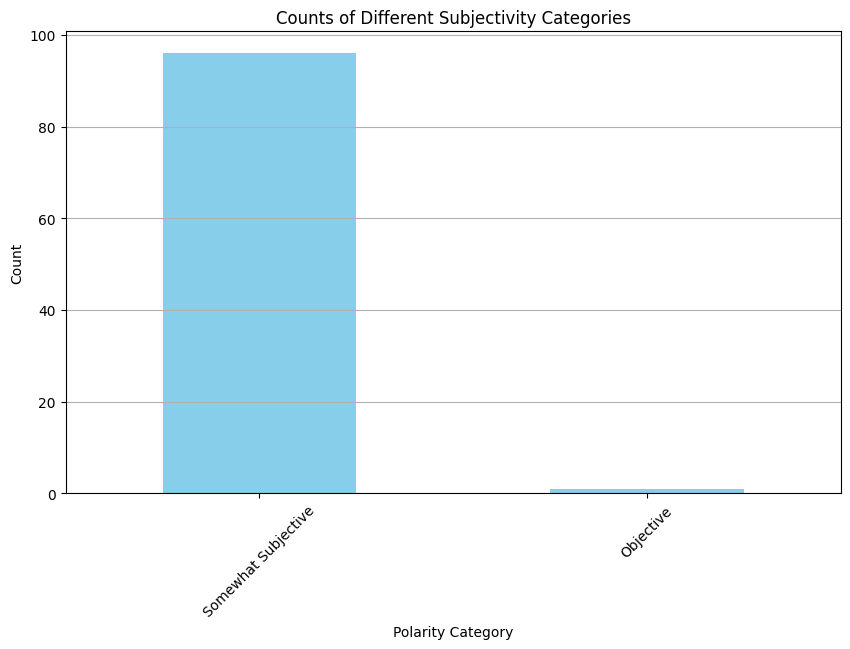

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- POLARITY
# Count the occurrences of each category
category_counts_pol = df_test['Polarity Category'].value_counts()

# Print the counts
print(category_counts_pol)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_pol.plot(kind='bar', color='skyblue')
plt.title('Counts of Different Polarity Categories')
plt.xlabel('Polarity Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# ---- SUBJECTIVITY
# Count the occurrences of each category
category_counts_sub = df_test['Subjectivity Category'].value_counts()

# Print the counts
print(category_counts_sub)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_sub.plot(kind='bar', color='skyblue')
plt.title('Counts of Different Subjectivity Categories')
plt.xlabel('Polarity Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [13]:
# - GETTING SENTIMENT ON WITH OTHER MODEL - MOVE UP (THIS IS WITH TRUNCATION 512 tokens)
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load the sentiment analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(sentiment_model_path)
model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path)
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
def get_sentiment_score(article):
    # Encode and truncate the text to fit within the model's token limit (512 tokens)
    inputs = tokenizer(article, return_tensors="pt", max_length=512, truncation=True)

    # Get sentiment score
    with torch.no_grad():  # Disable gradient calculations for inference
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Use the correct indices based on the label names
        score_positive = predictions[:, model.config.label2id['positive']].item()
        score_negative = predictions[:, model.config.label2id['negative']].item()
        score_neutral = predictions[:, model.config.label2id['neutral']].item()

    # You can modify the return value based on how you want to represent the sentiment score
    # For instance, returning the highest score among the three
    return max(score_positive, score_negative, score_neutral)

# Apply the function to the 'Article Body' column
df_test['sentiment_score_roberta_base'] = df_test['Article Body'].apply(get_sentiment_score)
df_test

,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url,Polarity,Subjectivity,AI_POS,AI_NEU,AI_NEG,Polarity Category,Subjectivity Category,sentiment_score_roberta_base
0,"december 17, 2023",Pranshu Verma,The Washington Post,The rise of AI fake news is creating a ‘misinf...,AI is making it easy for anyone to create prop...,Artificial intelligence is automating the crea...,https://www.washingtonpost.com/technology/2023...,0.044660,0.473436,0.322779,0.206170,0.471051,Neutral,Somewhat Subjective,0.572445
1,"May 30, 2023",Matt O'Brien,AP News,Artificial intelligence raises risk of extinct...,NaN,"Scientists and tech industry leaders, includin...",https://apnews.com/article/artificial-intellig...,0.089084,0.455128,0.324569,0.324077,0.351353,Neutral,Somewhat Subjective,0.416932
2,"december 14, 2023",Nicole Winfield,AP News,"Pope, once a victim of AI-generated imagery, c...",NaN,ROME (AP) — Pope Francis on Thursday called fo...,https://apnews.com/article/vatican-pope-ai-art...,0.028099,0.435061,0.467939,0.294264,0.237797,Neutral,Somewhat Subjective,0.387546
3,"december 14, 2023",Matt O'Brien,AP News,2023: The year we played with artificial intel...,NaN,Artificial intelligence went mainstream in 202...,https://apnews.com/article/ai-2023-artificial-...,0.111853,0.506686,0.286163,0.140989,0.572848,Neutral,Somewhat Subjective,0.465818
4,"october 25, 2023",Matt O'Brien and Haleluya Hadero,AP News,AI-generated child sexual abuse images could f...,NaN,NEW YORK (AP) — The already-alarming prolifera...,https://apnews.com/article/ai-artificial-intel...,0.101039,0.540597,0.325153,0.128224,0.546623,Neutral,Somewhat Subjective,0.495334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"March 9, 2021",Sharona Hoffman,The conversation,Biased AI can be bad for your health – here’s ...,NaN,Artificial intelligence holds great promise fo...,https://theconversation.com/biased-ai-can-be-b...,0.094630,0.476450,0.214857,0.117002,0.668141,Neutral,Somewhat Subjective,0.426051
93,"february 14, 2020",Michele Gilman,The conversation,AI algorithms intended to root out welfare fra...,NaN,President Donald Trump recently suggested ther...,https://theconversation.com/ai-algorithms-inte...,0.012950,0.448182,0.201850,0.126729,0.671420,Neutral,Somewhat Subjective,0.640104
94,"march 16, 2023",Ashley M. Hopkins,The conversation,We asked ChatGPT and Dr Google the same questi...,NaN,"You may have heard the buzz about ChatGPT, a t...",https://theconversation.com/we-asked-chatgpt-a...,0.077810,0.469568,0.402393,0.096331,0.501276,Neutral,Somewhat Subjective,0.410608
95,"march 5, 2023",Jordan Richard Schoenherr,The conversation,Generative AI like ChatGPT reveal deep-seated ...,NaN,ChatGPT has cast long shadows over the media a...,https://theconversation.com/generative-ai-like...,0.066848,0.451615,0.091764,0.060656,0.847580,Neutral,Somewhat Subjective,0.438980


In [14]:
# Categorize
def categorize_sentiment_strict(score):
    if score < -0.25:
        return 'Negative'
    elif score > 0.25:
        return 'Positive'
    else:
        return 'Neutral'

# Apply the function to create a new column with sentiment labels
df_test['sentiment_label_roberta_base'] = df_test['sentiment_score_roberta_base'].apply(categorize_sentiment_strict)
df_test

,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url,Polarity,Subjectivity,AI_POS,AI_NEU,AI_NEG,Polarity Category,Subjectivity Category,sentiment_score_roberta_base,sentiment_label_roberta_base
0,"december 17, 2023",Pranshu Verma,The Washington Post,The rise of AI fake news is creating a ‘misinf...,AI is making it easy for anyone to create prop...,Artificial intelligence is automating the crea...,https://www.washingtonpost.com/technology/2023...,0.044660,0.473436,0.322779,0.206170,0.471051,Neutral,Somewhat Subjective,0.572445,Positive
1,"May 30, 2023",Matt O'Brien,AP News,Artificial intelligence raises risk of extinct...,NaN,"Scientists and tech industry leaders, includin...",https://apnews.com/article/artificial-intellig...,0.089084,0.455128,0.324569,0.324077,0.351353,Neutral,Somewhat Subjective,0.416932,Positive
2,"december 14, 2023",Nicole Winfield,AP News,"Pope, once a victim of AI-generated imagery, c...",NaN,ROME (AP) — Pope Francis on Thursday called fo...,https://apnews.com/article/vatican-pope-ai-art...,0.028099,0.435061,0.467939,0.294264,0.237797,Neutral,Somewhat Subjective,0.387546,Positive
3,"december 14, 2023",Matt O'Brien,AP News,2023: The year we played with artificial intel...,NaN,Artificial intelligence went mainstream in 202...,https://apnews.com/article/ai-2023-artificial-...,0.111853,0.506686,0.286163,0.140989,0.572848,Neutral,Somewhat Subjective,0.465818,Positive
4,"october 25, 2023",Matt O'Brien and Haleluya Hadero,AP News,AI-generated child sexual abuse images could f...,NaN,NEW YORK (AP) — The already-alarming prolifera...,https://apnews.com/article/ai-artificial-intel...,0.101039,0.540597,0.325153,0.128224,0.546623,Neutral,Somewhat Subjective,0.495334,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"March 9, 2021",Sharona Hoffman,The conversation,Biased AI can be bad for your health – here’s ...,NaN,Artificial intelligence holds great promise fo...,https://theconversation.com/biased-ai-can-be-b...,0.094630,0.476450,0.214857,0.117002,0.668141,Neutral,Somewhat Subjective,0.426051,Positive
93,"february 14, 2020",Michele Gilman,The conversation,AI algorithms intended to root out welfare fra...,NaN,President Donald Trump recently suggested ther...,https://theconversation.com/ai-algorithms-inte...,0.012950,0.448182,0.201850,0.126729,0.671420,Neutral,Somewhat Subjective,0.640104,Positive
94,"march 16, 2023",Ashley M. Hopkins,The conversation,We asked ChatGPT and Dr Google the same questi...,NaN,"You may have heard the buzz about ChatGPT, a t...",https://theconversation.com/we-asked-chatgpt-a...,0.077810,0.469568,0.402393,0.096331,0.501276,Neutral,Somewhat Subjective,0.410608,Positive
95,"march 5, 2023",Jordan Richard Schoenherr,The conversation,Generative AI like ChatGPT reveal deep-seated ...,NaN,ChatGPT has cast long shadows over the media a...,https://theconversation.com/generative-ai-like...,0.066848,0.451615,0.091764,0.060656,0.847580,Neutral,Somewhat Subjective,0.438980,Positive


sentiment_label_roberta_base
Positive    97
Name: count, dtype: int64


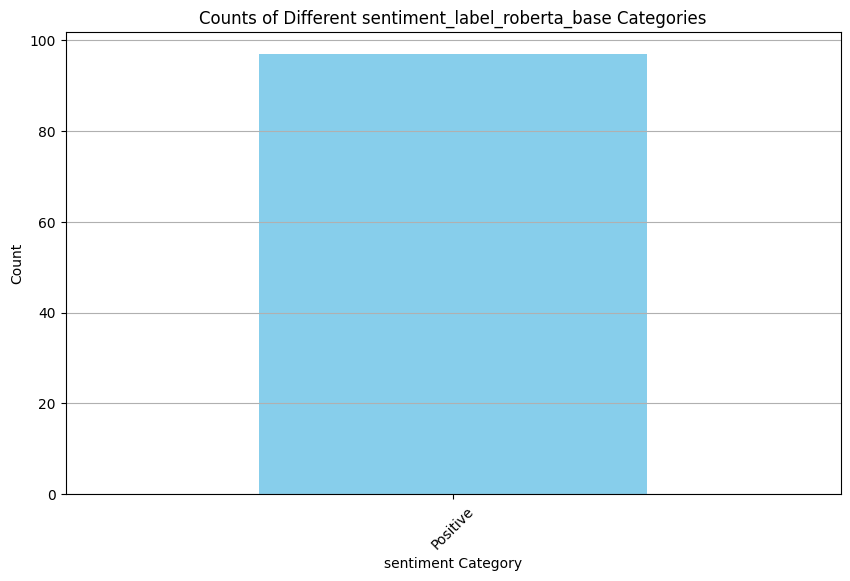

In [15]:

# ---- SENTIMENT PLOT
# Count the occurrences of each category
category_counts_sent = df_test['sentiment_label_roberta_base'].value_counts()

# Print the counts
print(category_counts_sent)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_sent.plot(kind='bar', color='skyblue')
plt.title('Counts of Different sentiment_label_roberta_base Categories')
plt.xlabel('sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [16]:
# --- ABSA
import pandas as pd

# Function to find the column with the maximum score
def find_max_label(row):
    # Extracting the scores for 'AI' from the row
    scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
    # Finding the key with the maximum score
    max_label = max(scores, key=scores.get)
    return max_label

# Apply the function to each row to create the 'AI_label' column
df_test['AI_label'] = df_test.apply(find_max_label, axis=1)

# Displaying the first few rows of the updated DataFrame
df_test

,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url,Polarity,Subjectivity,AI_POS,AI_NEU,AI_NEG,Polarity Category,Subjectivity Category,sentiment_score_roberta_base,sentiment_label_roberta_base,AI_label
0,"december 17, 2023",Pranshu Verma,The Washington Post,The rise of AI fake news is creating a ‘misinf...,AI is making it easy for anyone to create prop...,Artificial intelligence is automating the crea...,https://www.washingtonpost.com/technology/2023...,0.044660,0.473436,0.322779,0.206170,0.471051,Neutral,Somewhat Subjective,0.572445,Positive,AI_NEG
1,"May 30, 2023",Matt O'Brien,AP News,Artificial intelligence raises risk of extinct...,NaN,"Scientists and tech industry leaders, includin...",https://apnews.com/article/artificial-intellig...,0.089084,0.455128,0.324569,0.324077,0.351353,Neutral,Somewhat Subjective,0.416932,Positive,AI_NEG
2,"december 14, 2023",Nicole Winfield,AP News,"Pope, once a victim of AI-generated imagery, c...",NaN,ROME (AP) — Pope Francis on Thursday called fo...,https://apnews.com/article/vatican-pope-ai-art...,0.028099,0.435061,0.467939,0.294264,0.237797,Neutral,Somewhat Subjective,0.387546,Positive,AI_POS
3,"december 14, 2023",Matt O'Brien,AP News,2023: The year we played with artificial intel...,NaN,Artificial intelligence went mainstream in 202...,https://apnews.com/article/ai-2023-artificial-...,0.111853,0.506686,0.286163,0.140989,0.572848,Neutral,Somewhat Subjective,0.465818,Positive,AI_NEG
4,"october 25, 2023",Matt O'Brien and Haleluya Hadero,AP News,AI-generated child sexual abuse images could f...,NaN,NEW YORK (AP) — The already-alarming prolifera...,https://apnews.com/article/ai-artificial-intel...,0.101039,0.540597,0.325153,0.128224,0.546623,Neutral,Somewhat Subjective,0.495334,Positive,AI_NEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"March 9, 2021",Sharona Hoffman,The conversation,Biased AI can be bad for your health – here’s ...,NaN,Artificial intelligence holds great promise fo...,https://theconversation.com/biased-ai-can-be-b...,0.094630,0.476450,0.214857,0.117002,0.668141,Neutral,Somewhat Subjective,0.426051,Positive,AI_NEG
93,"february 14, 2020",Michele Gilman,The conversation,AI algorithms intended to root out welfare fra...,NaN,President Donald Trump recently suggested ther...,https://theconversation.com/ai-algorithms-inte...,0.012950,0.448182,0.201850,0.126729,0.671420,Neutral,Somewhat Subjective,0.640104,Positive,AI_NEG
94,"march 16, 2023",Ashley M. Hopkins,The conversation,We asked ChatGPT and Dr Google the same questi...,NaN,"You may have heard the buzz about ChatGPT, a t...",https://theconversation.com/we-asked-chatgpt-a...,0.077810,0.469568,0.402393,0.096331,0.501276,Neutral,Somewhat Subjective,0.410608,Positive,AI_NEG
95,"march 5, 2023",Jordan Richard Schoenherr,The conversation,Generative AI like ChatGPT reveal deep-seated ...,NaN,ChatGPT has cast long shadows over the media a...,https://theconversation.com/generative-ai-like...,0.066848,0.451615,0.091764,0.060656,0.847580,Neutral,Somewhat Subjective,0.438980,Positive,AI_NEG


AI_label
AI_NEG    58
AI_POS    35
AI_NEU     4
Name: count, dtype: int64


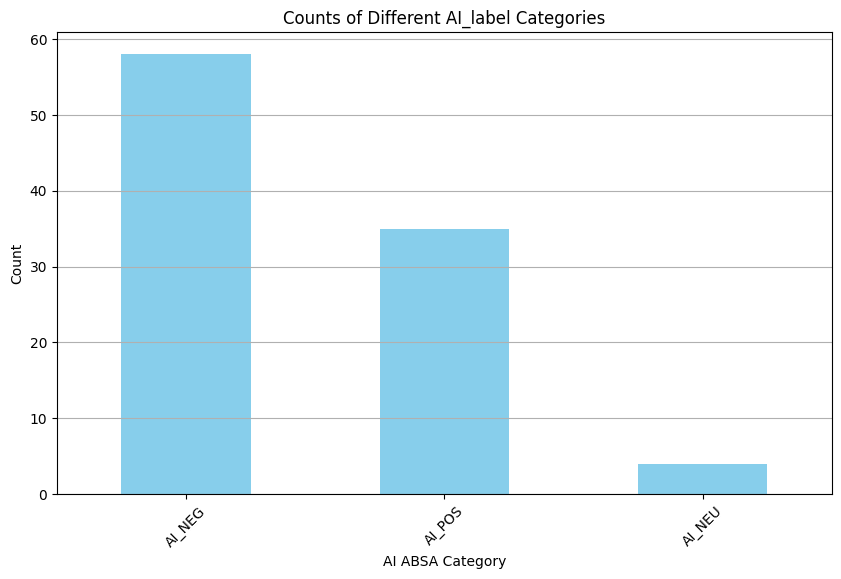

In [17]:

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = df_test['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Chunk them and check

In [40]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document


# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in df_test.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)

# Split doc into nodes
nodes = text_splitter.get_nodes_from_documents(documents)

# Df
nodes_df = pd.DataFrame(nodes)

nodes_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,"(id_, 3c9a4f80-cb9c-463b-bf44-79866ec1c457)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 15adbc9d762c8a15c5e4d23b99ac5d4b193f163...","(text, Artificial intelligence is automating t...","(start_char_idx, 0)","(end_char_idx, 2234)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
1,"(id_, d493027e-2787-42a4-8a81-580a56448d5f)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 3cfb958d41fc1a475912c945a35bfe08827833f...","(text, A growing number of websites, with gene...","(start_char_idx, 2235)","(end_char_idx, 4428)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
2,"(id_, df9ebe2b-ff39-413b-a8bc-19f52c7b24d9)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, a87406bef9fcffd8f7cb62ce38fcb66c0476118...","(text, The result is automatically posted onli...","(start_char_idx, 4429)","(end_char_idx, 6571)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
3,"(id_, 74ef330c-3f99-48ee-8aef-f9884ab15d53)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 5503a5801100f69180806f7f7e3a6861abaca07...","(text, Just because something claims to be a n...","(start_char_idx, 6572)","(end_char_idx, 7213)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
4,"(id_, ff3c9618-8859-439f-9e99-5e9b70772f22)","(embedding, None)","(metadata, {'title': 'Artificial intelligence ...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 631f3998ba42d3261bc8f06d99530f34b775433...","(text, Scientists and tech industry leaders, i...","(start_char_idx, 0)","(end_char_idx, 2073)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,"(id_, 078ba6d8-28f2-4f23-a86b-8c73f34e558c)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8284b929c79d783a531dcca36b6ad50ba321d83...","(text, The greater the distance between cultur...","(start_char_idx, 2217)","(end_char_idx, 4488)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
300,"(id_, 927c9ba9-9522-422c-82ce-44d90ff1a334)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 803d25bb3b22517c840c9805b572933f04f1e15...","(text, This pattern follows a general trend of...","(start_char_idx, 4489)","(end_char_idx, 6627)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)"
301,"(id_, 59419067-14e7-41cd-9002-508611c52716)","(embedding, None)","(metadata, {'title': 'Unlike with academics an...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 9aa5bb910bab943a7b2b75f573018d5f3cb1356...","(text, Of all the reactions elicited by ChatGP...","(start_ch

In [41]:
# --- Run ABSA on the chunked articles

nodes_df.rename(columns={7: 'Article Body'}, inplace=True)
nodes_df['Article Body'] = nodes_df['Article Body'].astype(str)
print(type(nodes_df['Article Body']))
nodes_df_abs = run_absa_for_dataframe(nodes_df, aspects)
print("Done with ABSA.")

nodes_df_abs

<class 'pandas.core.series.Series'>
Done with ABSA.


,0,1,2,3,4,5,6,Article Body,8,9,10,11,12,AI_POS,AI_NEU,AI_NEG
0,"(id_, 3c9a4f80-cb9c-463b-bf44-79866ec1c457)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 15adbc9d762c8a15c5e4d23b99ac5d4b193f163...","('text', 'Artificial intelligence is automatin...","(start_char_idx, 0)","(end_char_idx, 2234)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.165363,0.190948,0.643689
1,"(id_, d493027e-2787-42a4-8a81-580a56448d5f)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 3cfb958d41fc1a475912c945a35bfe08827833f...","('text', 'A growing number of websites, with g...","(start_char_idx, 2235)","(end_char_idx, 4428)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.189898,0.282628,0.527474
2,"(id_, df9ebe2b-ff39-413b-a8bc-19f52c7b24d9)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, a87406bef9fcffd8f7cb62ce38fcb66c0476118...","('text', 'The result is automatically posted o...","(start_char_idx, 4429)","(end_char_idx, 6571)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.246369,0.270693,0.482938
3,"(id_, 74ef330c-3f99-48ee-8aef-f9884ab15d53)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 5503a5801100f69180806f7f7e3a6861abaca07...","('text', 'Just because something claims to be ...","(start_char_idx, 6572)","(end_char_idx, 7213)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.126115,0.291335,0.582550
4,"(id_, ff3c9618-8859-439f-9e99-5e9b70772f22)","(embedding, None)","(metadata, {'title': 'Artificial intelligence ...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 631f3998ba42d3261bc8f06d99530f34b775433...","('text', 'Scientists and tech industry leaders...","(start_char_idx, 0)","(end_char_idx, 2073)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.409896,0.400262,0.189842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,"(id_, 078ba6d8-28f2-4f23-a86b-8c73f34e558c)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8284b929c79d783a531dcca36b6ad50ba321d83...","('text', 'The greater the distance between cul...","(start_char_idx, 2217)","(end_char_idx, 4488)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.242166,0.287448,0.470386
300,"(id_, 927c9ba9-9522-422c-82ce-44d90ff1a334)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 803d25bb3b22517c840c9805b572933f04f1e15...","('text', 'This pattern follows a general trend...","(start_char_idx, 4489)","(end_char_idx, 6627)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.088315,0.122479,0.789206
301,"(id_, 59419067-14e7-41cd-9002-508611c52716)","(embedding, None)","(metadata, {'title': 'Unlike with academics an...","(exc

/tmp/ipykernel_481473/362952980.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_481473/362952980.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_481473/362952980.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


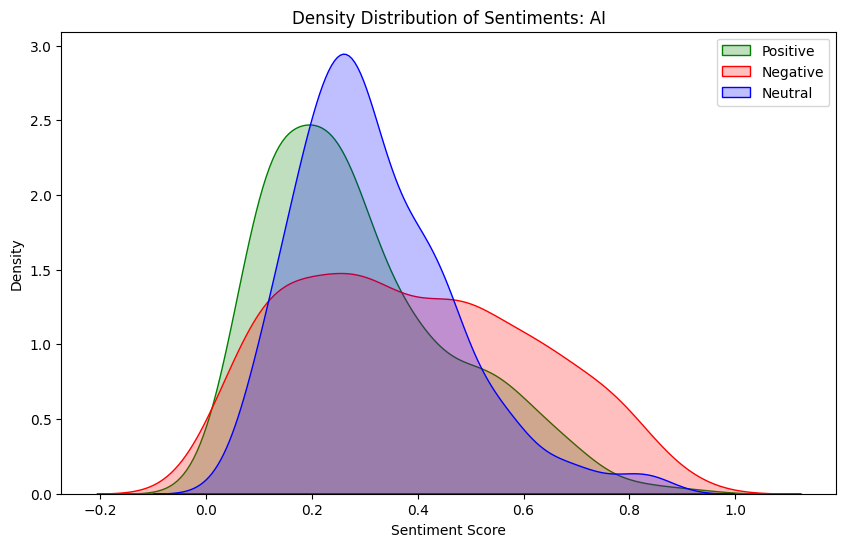

In [42]:

# Plot

import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_df_abs[f'{aspect}_POS'],
                               neg_list = nodes_df_abs[f'{aspect}_NEG'],
                               neu_list = nodes_df_abs[f'{aspect}_NEU'])  



In [43]:
# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
nodes_df_abs['AI_label'] = nodes_df_abs.apply(find_max_label, axis=1)

# Displaying the first few rows of the updated DataFrame
nodes_df_abs

,0,1,2,3,4,5,6,Article Body,8,9,10,11,12,AI_POS,AI_NEU,AI_NEG,AI_label
0,"(id_, 3c9a4f80-cb9c-463b-bf44-79866ec1c457)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 15adbc9d762c8a15c5e4d23b99ac5d4b193f163...","('text', 'Artificial intelligence is automatin...","(start_char_idx, 0)","(end_char_idx, 2234)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.165363,0.190948,0.643689,AI_NEG
1,"(id_, d493027e-2787-42a4-8a81-580a56448d5f)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 3cfb958d41fc1a475912c945a35bfe08827833f...","('text', 'A growing number of websites, with g...","(start_char_idx, 2235)","(end_char_idx, 4428)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.189898,0.282628,0.527474,AI_NEG
2,"(id_, df9ebe2b-ff39-413b-a8bc-19f52c7b24d9)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, a87406bef9fcffd8f7cb62ce38fcb66c0476118...","('text', 'The result is automatically posted o...","(start_char_idx, 4429)","(end_char_idx, 6571)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.246369,0.270693,0.482938,AI_NEG
3,"(id_, 74ef330c-3f99-48ee-8aef-f9884ab15d53)","(embedding, None)","(metadata, {'title': 'The rise of AI fake news...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 5503a5801100f69180806f7f7e3a6861abaca07...","('text', 'Just because something claims to be ...","(start_char_idx, 6572)","(end_char_idx, 7213)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.126115,0.291335,0.582550,AI_NEG
4,"(id_, ff3c9618-8859-439f-9e99-5e9b70772f22)","(embedding, None)","(metadata, {'title': 'Artificial intelligence ...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 631f3998ba42d3261bc8f06d99530f34b775433...","('text', 'Scientists and tech industry leaders...","(start_char_idx, 0)","(end_char_idx, 2073)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.409896,0.400262,0.189842,AI_POS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,"(id_, 078ba6d8-28f2-4f23-a86b-8c73f34e558c)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8284b929c79d783a531dcca36b6ad50ba321d83...","('text', 'The greater the distance between cul...","(start_char_idx, 2217)","(end_char_idx, 4488)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.242166,0.287448,0.470386,AI_NEG
300,"(id_, 927c9ba9-9522-422c-82ce-44d90ff1a334)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 803d25bb3b22517c840c9805b572933f04f1e15...","('text', 'This pattern follows a general trend...","(start_char_idx, 4489)","(end_char_idx, 6627)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.088315,0.122479,0.789206,AI_NEG
301,"(id_, 59419067-14e7-41cd-9002-508611c52716)","(embedding, No

AI_label
AI_NEG    145
AI_NEU     82
AI_POS     77
Name: count, dtype: int64


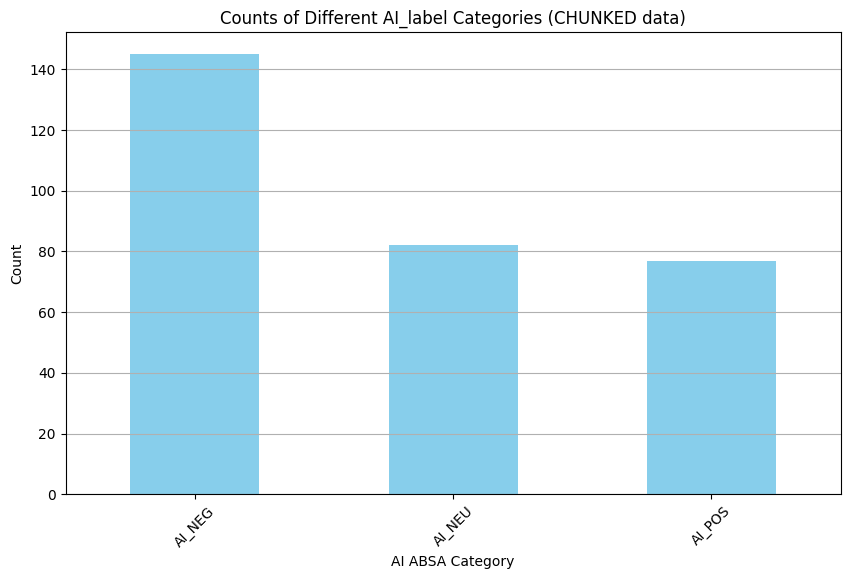

In [44]:

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = nodes_df_abs['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (CHUNKED data)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Add newest articles (23rd of december on to dataframe with MIT AI NEWS)

In [53]:
# Add the newest articles on
import pandas as pd

# MIT data
MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])

# New articles
extra_art_23dec = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ['Unnamed: 0'])

# Merge
articles_aug = pd.concat([MIT_ai_news, extra_art_23dec]).drop(columns = ['comment'])

# Take a look
articles_aug

,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url
0,"July 7, 2023",Adam Zewe,MIT News Office,Learning the language of molecules to predict ...,This AI system only needs a small amount of da...,['Discovering new materials and drugs typicall...,https://news.mit.edu/2023/learning-language-mo...
1,"July 6, 2023",Alex Ouyang,Abdul Latif Jameel Clinic for Machine Learning...,MIT scientists build a system that can generat...,"BioAutoMATED, an open-source, automated machin...",['Is it possible to build machine-learning mod...,https://news.mit.edu/2023/bioautomated-open-so...
2,"June 30, 2023",Jennifer Michalowski,McGovern Institute for Brain Research,"When computer vision works more like a brain, ...",Training artificial neural networks with data ...,"['From cameras to self-driving cars, many of t...",https://news.mit.edu/2023/when-computer-vision...
3,"June 30, 2023",Mary Beth Gallagher,School of Engineering,Educating national security leaders on artific...,"Experts from MIT’s School of Engineering, Schw...",['Understanding artificial intelligence and ho...,https://news.mit.edu/2023/educating-national-s...
4,"June 30, 2023",Adam Zewe,MIT News Office,Researchers teach an AI to write better chart ...,A new dataset can help scientists develop auto...,['Chart captions that explain complex trends a...,https://news.mit.edu/2023/researchers-chart-ca...
...,...,...,...,...,...,...,...
92,"March 9, 2021",Sharona Hoffman,The conversation,Biased AI can be bad for your health – here’s ...,NaN,Artificial intelligence holds great promise fo...,https://theconversation.com/biased-ai-can-be-b...
93,"february 14, 2020",Michele Gilman,The conversation,AI algorithms intended to root out welfare fra...,NaN,President Donald Trump recently suggested ther...,https://theconversation.com/ai-algorithms-inte...
94,"march 16, 2023",Ashley M. Hopkins,The conversation,We asked ChatGPT and Dr Google the same questi...,NaN,"You may have heard the buzz about ChatGPT, a t...",https://theconversation.com/we-asked-chatgpt-a...
95,"march 5, 2023",Jordan Richard Schoenherr,The conversation,Generative AI like ChatGPT reveal deep-seated ...,NaN,ChatGPT has cast long shadows over the media a...,https://theconversation.com/generative-ai-like...


In [54]:
# Chunk it all
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document


# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in articles_aug.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)

# Split doc into nodes
nodes = text_splitter.get_nodes_from_documents(documents)

# Df
nodes_df = pd.DataFrame(nodes)

In [57]:
# Inspect for sentiment and attempt to balance it

# --- Run ABSA on the chunked articles
nodes_df.rename(columns={7: 'Article Body'}, inplace=True)
nodes_df['Article Body'] = nodes_df['Article Body'].astype(str)
print(type(nodes_df['Article Body']))
nodes_df_abs = run_absa_for_dataframe(nodes_df, aspects)
print("Done with ABSA.")

nodes_df_abs

<class 'pandas.core.series.Series'>
Done with ABSA.


,0,1,2,3,4,5,6,Article Body,8,9,10,11,12,AI_POS,AI_NEU,AI_NEG
0,"(id_, cfec3a77-de78-41a2-bfde-91e916b4f2ea)","(embedding, None)","(metadata, {'title': 'Learning the language of...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, c1031dc183adef16e1e71b06b300c44bfcd6871...","('text', ""['Discovering new materials and drug...","(start_char_idx, 0)","(end_char_idx, 2391)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.612922,0.299267,0.087811
1,"(id_, 74e0b88c-bada-478d-9325-98ee46d9d3db)","(embedding, None)","(metadata, {'title': 'Learning the language of...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, d3adb4f12602a0dd4603ba63ed6d231e13ef1b8...","('text', ""The research will be presented at th...","(start_char_idx, 2392)","(end_char_idx, 4711)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.299072,0.601759,0.099169
2,"(id_, f3fe802a-5bc9-4287-b7cb-f0e5ef292727)","(embedding, None)","(metadata, {'title': 'Learning the language of...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8739902b4ba8e0ab96e5d69e3cd0697f9394e23...","('text', ""The first part, called a metagrammar...","(start_char_idx, 4712)","(end_char_idx, 6718)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.870380,0.097515,0.032106
3,"(id_, 607ab561-6c66-4408-9979-c9ea38c13a38)","(embedding, None)","(metadata, {'title': 'MIT scientists build a s...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 6e8df09a35c5a293e035c5ab4bf0c112af26b98...","('text', '[\'Is it possible to build machine-l...","(start_char_idx, 0)","(end_char_idx, 1967)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.353391,0.507609,0.139000
4,"(id_, e452d1f5-ec58-4c4a-854f-45645e9a2209)","(embedding, None)","(metadata, {'title': 'MIT scientists build a s...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, e9437c3ec387af802047b225eadb73c8836f4f2...","('text', 'Automated machine-learning (AutoML) ...","(start_char_idx, 1968)","(end_char_idx, 4069)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.264757,0.623179,0.112064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3297,"(id_, 29c8c620-9fd0-498c-9dbf-92e6cc720ec4)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8284b929c79d783a531dcca36b6ad50ba321d83...","('text', 'The greater the distance between cul...","(start_char_idx, 2217)","(end_char_idx, 4488)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.242166,0.287448,0.470386
3298,"(id_, df212c2e-2e8a-427c-a1e9-c2eb1395a96b)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 803d25bb3b22517c840c9805b572933f04f1e15...","('text', 'This pattern follows a general trend...","(start_char_idx, 4489)","(end_char_idx, 6627)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.088315,0.122479,0.789206
3299,"(id_, 5c96eb86-4fe2-4866-846d-bed0e3fa4dd1)","(embedding, None)","(metadata, {'title': 'Unlike with academics an..."

/tmp/ipykernel_481473/362952980.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_481473/362952980.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_481473/362952980.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


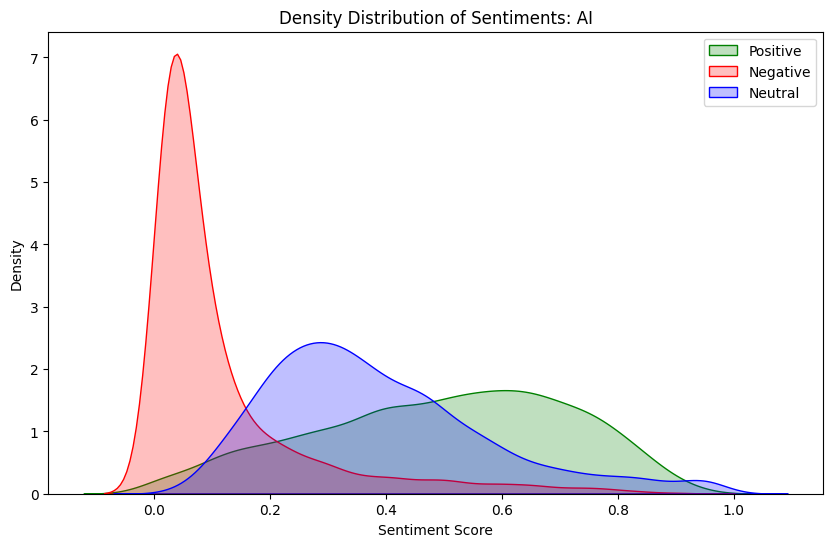

AI_label
AI_POS    2011
AI_NEU    1049
AI_NEG     242
Name: count, dtype: int64


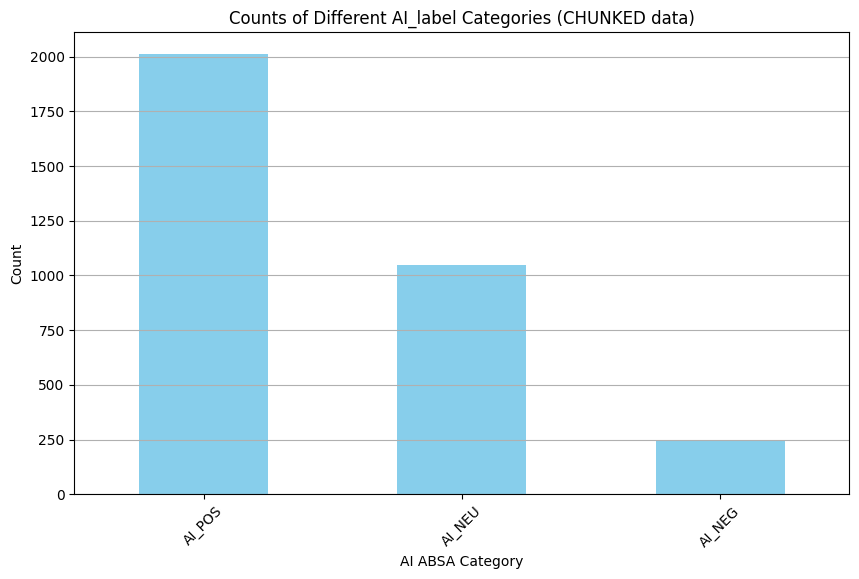

In [58]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_df_abs[f'{aspect}_POS'],
                               neg_list = nodes_df_abs[f'{aspect}_NEG'],
                               neu_list = nodes_df_abs[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
nodes_df_abs['AI_label'] = nodes_df_abs.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = nodes_df_abs['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (CHUNKED data)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# MIT AI NEWS dataset - distribution of sentiment in chunks


<class 'pandas.core.series.Series'>
Done with ABSA.


/tmp/ipykernel_481473/362952980.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_481473/362952980.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_481473/362952980.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


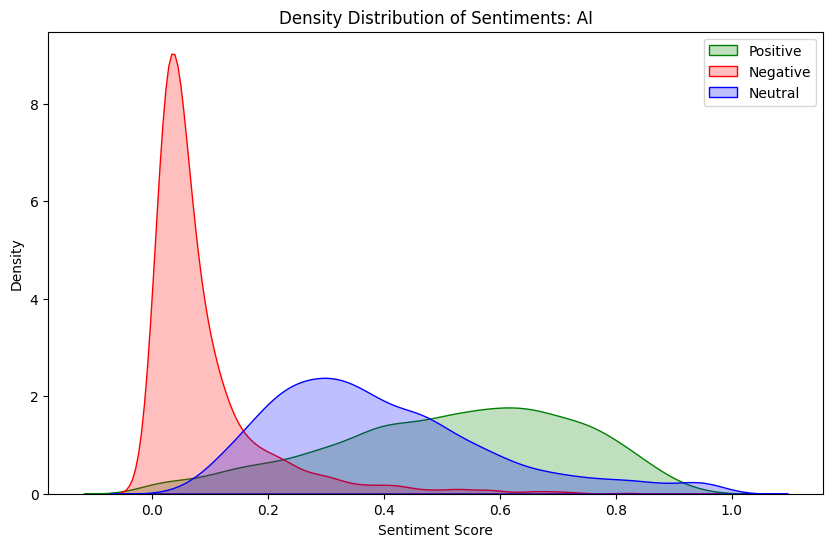

AI_label
AI_POS    1934
AI_NEU     967
AI_NEG      97
Name: count, dtype: int64


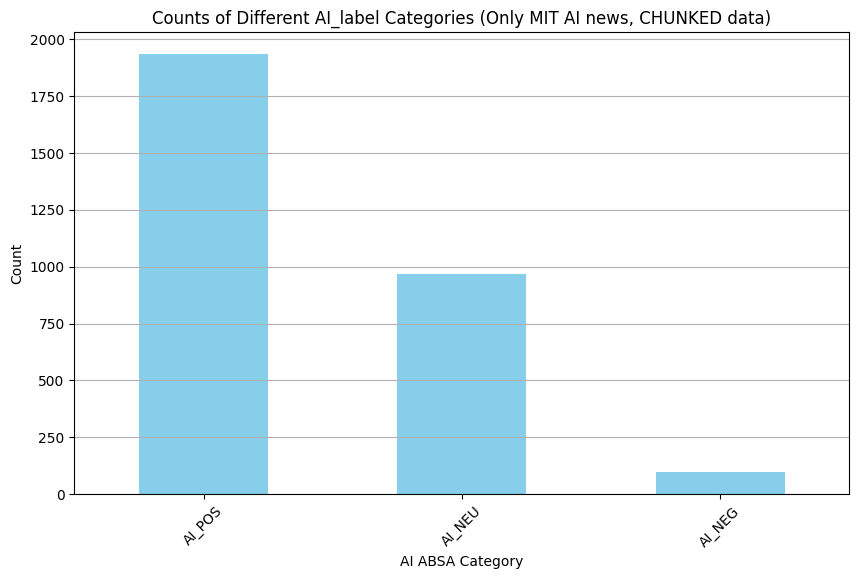

In [59]:
# Add the newest articles on
import pandas as pd

# MIT data
MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])

# Chunk it all
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document


# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in MIT_ai_news.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)

# Split doc into nodes
nodes = text_splitter.get_nodes_from_documents(documents)

# Df
nodes_df = pd.DataFrame(nodes)

# --- Run ABSA on the chunked articles
nodes_df.rename(columns={7: 'Article Body'}, inplace=True)
nodes_df['Article Body'] = nodes_df['Article Body'].astype(str)
print(type(nodes_df['Article Body']))
nodes_df_abs = run_absa_for_dataframe(nodes_df, aspects)
print("Done with ABSA.")

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_df_abs[f'{aspect}_POS'],
                               neg_list = nodes_df_abs[f'{aspect}_NEG'],
                               neu_list = nodes_df_abs[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
nodes_df_abs['AI_label'] = nodes_df_abs.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = nodes_df_abs['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Only MIT AI news, CHUNKED data)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Trying to balance out some of the articles


In [60]:
# ------ Taking the augmented dataset in chunks

# Add the newest articles on
import pandas as pd

# MIT data
MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])

# New articles
extra_art_23dec = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ['Unnamed: 0'])

# Merge
articles_aug = pd.concat([MIT_ai_news, extra_art_23dec]).drop(columns = ['comment'])

# Chunk it all
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document


# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in articles_aug.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)

# Split doc into nodes
nodes = text_splitter.get_nodes_from_documents(documents)

# Df
nodes_df = pd.DataFrame(nodes)

# --- Run ABSA on the chunked articles
nodes_df.rename(columns={7: 'Article Body'}, inplace=True)
nodes_df['Article Body'] = nodes_df['Article Body'].astype(str)
print(type(nodes_df['Article Body']))
nodes_df_abs = run_absa_for_dataframe(nodes_df, aspects)
print("Done with ABSA.")

nodes_df_abs

<class 'pandas.core.series.Series'>
Done with ABSA.


,0,1,2,3,4,5,6,Article Body,8,9,10,11,12,AI_POS,AI_NEU,AI_NEG
0,"(id_, b54c7a9e-f9e8-4e7c-8977-3fcb4c6d1de5)","(embedding, None)","(metadata, {'title': 'Learning the language of...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, c1031dc183adef16e1e71b06b300c44bfcd6871...","('text', ""['Discovering new materials and drug...","(start_char_idx, 0)","(end_char_idx, 2391)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.612922,0.299267,0.087811
1,"(id_, 4e143972-f2d4-4711-8ad9-fff8d953d888)","(embedding, None)","(metadata, {'title': 'Learning the language of...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, d3adb4f12602a0dd4603ba63ed6d231e13ef1b8...","('text', ""The research will be presented at th...","(start_char_idx, 2392)","(end_char_idx, 4711)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.299072,0.601759,0.099169
2,"(id_, 19be503f-4404-498e-a47f-21d9e5d93bba)","(embedding, None)","(metadata, {'title': 'Learning the language of...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8739902b4ba8e0ab96e5d69e3cd0697f9394e23...","('text', ""The first part, called a metagrammar...","(start_char_idx, 4712)","(end_char_idx, 6718)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.870380,0.097515,0.032106
3,"(id_, ae9877dd-bfdf-496a-9237-a20a664c9fcd)","(embedding, None)","(metadata, {'title': 'MIT scientists build a s...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 6e8df09a35c5a293e035c5ab4bf0c112af26b98...","('text', '[\'Is it possible to build machine-l...","(start_char_idx, 0)","(end_char_idx, 1967)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.353391,0.507609,0.139000
4,"(id_, 774e603f-f348-4ce8-8869-84e8178a9514)","(embedding, None)","(metadata, {'title': 'MIT scientists build a s...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, e9437c3ec387af802047b225eadb73c8836f4f2...","('text', 'Automated machine-learning (AutoML) ...","(start_char_idx, 1968)","(end_char_idx, 4069)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.264757,0.623179,0.112064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3297,"(id_, c06a19c8-cbf3-4a97-b927-85c50831093c)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 8284b929c79d783a531dcca36b6ad50ba321d83...","('text', 'The greater the distance between cul...","(start_char_idx, 2217)","(end_char_idx, 4488)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.242166,0.287448,0.470386
3298,"(id_, a257fb8f-44a7-4516-9db4-c76082a24066)","(embedding, None)","(metadata, {'title': 'Generative AI like ChatG...","(excluded_embed_metadata_keys, [])","(excluded_llm_metadata_keys, [])","(relationships, {'NodeRelationship.SOURCE': no...","(hash, 803d25bb3b22517c840c9805b572933f04f1e15...","('text', 'This pattern follows a general trend...","(start_char_idx, 4489)","(end_char_idx, 6627)","(text_template, {metadata_str}\n\n{content})","(metadata_template, {key}: {value})","(metadata_seperator, \n)",0.088315,0.122479,0.789206
3299,"(id_, 1b340296-71c2-47e1-b629-3062c94fd2e9)","(embedding, None)","(metadata, {'title': 'Unlike with academics an..."

## Prior to balancing


/tmp/ipykernel_481473/362952980.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_481473/362952980.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_481473/362952980.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


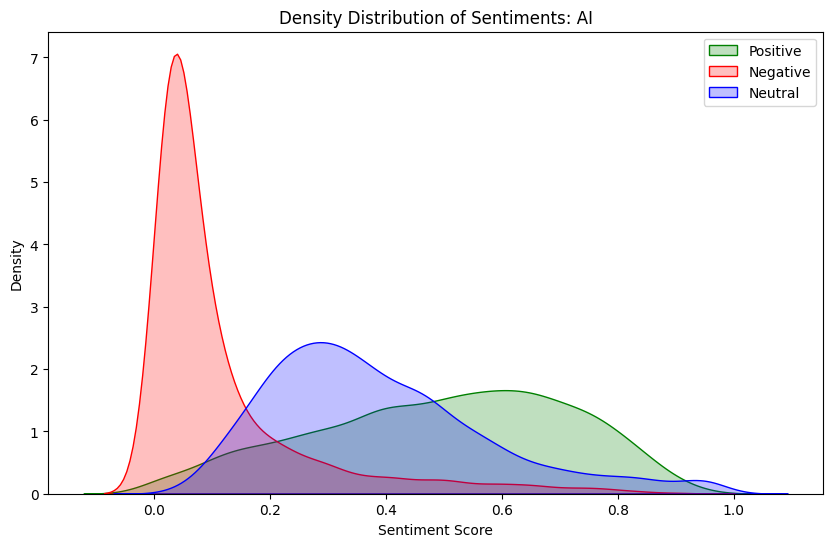

AI_label
AI_POS    2011
AI_NEU    1049
AI_NEG     242
Name: count, dtype: int64


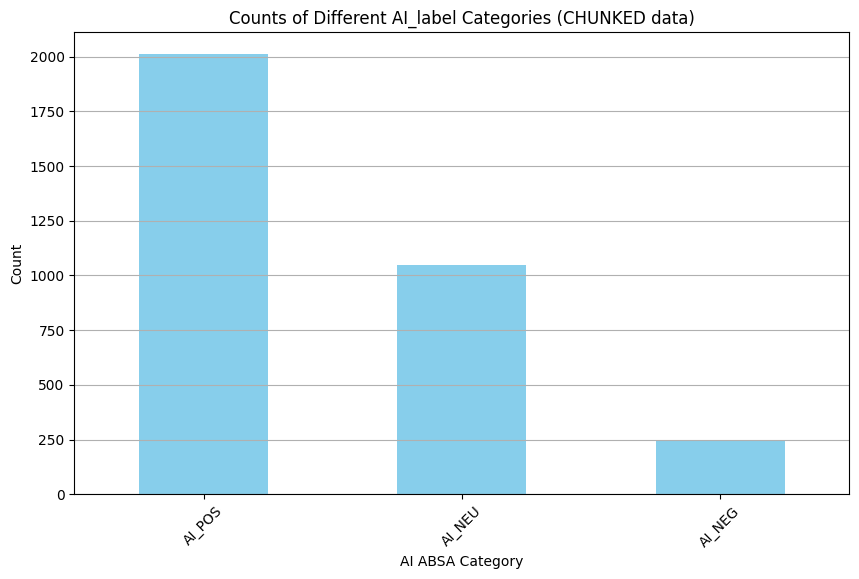

In [61]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_df_abs[f'{aspect}_POS'],
                               neg_list = nodes_df_abs[f'{aspect}_NEG'],
                               neu_list = nodes_df_abs[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
nodes_df_abs['AI_label'] = nodes_df_abs.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = nodes_df_abs['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (CHUNKED data)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Balancing attempts

In [ ]:
# -- Does it help to remove older articles? Remove based on metadata

# Get year in a column by itself
# - Rename col to metadata
nodes_df_abs.rename(columns={2: 'metadata'}, inplace=True)

# - Make as string
nodes_df_abs['metadata'] = nodes_df_abs['metadata'].astype(str)

# - Extract year from metadata col
import pandas as pd
from datetime import datetime

# Define a function to extract year from the metadata string
def extract_year(metadata_str):
    # Find the start and end index for the date value
    start_index = metadata_str.find("'date': '") + len("'date': '")
    end_index = metadata_str.find("',", start_index)
    date_str = metadata_str[start_index:end_index]
    # Parse the date string to a datetime object
    try:
        date_obj = datetime.strptime(date_str, '%B %d, %Y')
        return date_obj.year
    except ValueError:
        return None  # or some default value e.g., 0 or np.nan

# Apply the function to the 'metadata' column
nodes_df_abs['year'] = nodes_df_abs['metadata'].apply(extract_year)

print(nodes_df_abs['year'])

2001.0
2023.0


/tmp/ipykernel_481473/362952980.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_481473/362952980.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_481473/362952980.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


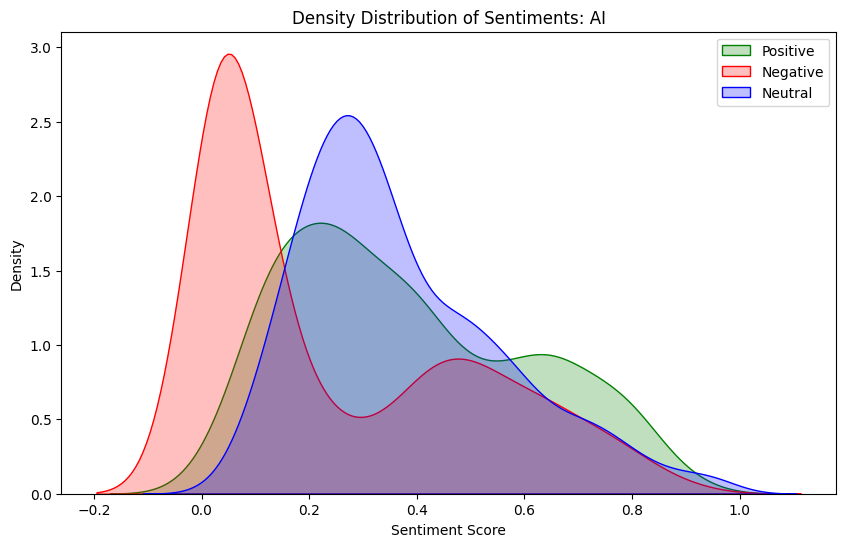

AI_label
AI_NEU    237
AI_POS    237
AI_NEG    237
Name: count, dtype: int64


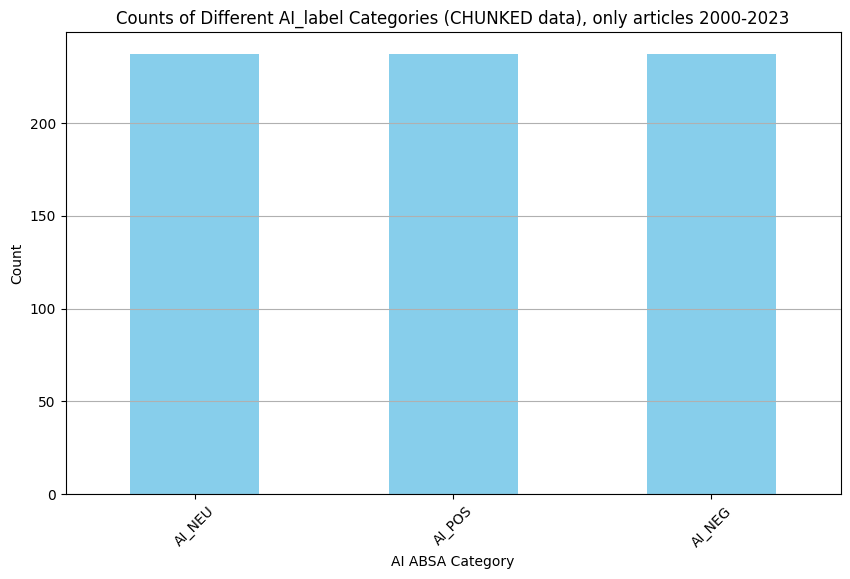

In [82]:
# - Remove 1994-2000
filtered_df = nodes_df_abs[~nodes_df_abs['year'].between(1994, 2000)]
print(filtered_df['year'].min())
print(filtered_df['year'].max())

# Check distribution now
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = filtered_df[f'{aspect}_POS'],
                               neg_list = filtered_df[f'{aspect}_NEG'],
                               neu_list = filtered_df[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
filtered_df['AI_label'] = filtered_df.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = filtered_df['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (CHUNKED data), only articles 2000-2023')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Trying to outsample positive chunks

In [81]:
# Randomly sampling out positive and old chunks
import pandas as pd
import numpy as np

# Assume df is your dataframe with columns 'chunk_id', 'text', 'sentiment_label'
np.random.seed(42)  # For reproducibility

# Get the counts for each sentiment category
counts = filtered_df['AI_label'].value_counts()

# Find the number of chunks to match (the minimum count across sentiments)
min_count = counts.min()

# Function to randomly drop excess chunks
def balance_chunks(dataframe, label, target_count):
    chunks_to_remove = dataframe[dataframe['AI_label'] == label].sample(n=(len(dataframe[dataframe['AI_label'] == label]) - target_count))
    return dataframe.drop(chunks_to_remove.index)

# Balance the dataframe
for sentiment in filtered_df['AI_label'].unique():
    filtered_df = balance_chunks(filtered_df, sentiment, min_count)

# Verify the new distribution
print( v['AI_label'].value_counts())

AI_label
AI_NEU    237
AI_POS    237
AI_NEG    237
Name: count, dtype: int64


# Post balancing

In [ ]:

# Check distribution now
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = filtered_df[f'{aspect}_POS'],
                               neg_list = filtered_df[f'{aspect}_NEG'],
                               neu_list = filtered_df[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
filtered_df['AI_label'] = filtered_df.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = filtered_df['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (CHUNKED data), only articles 2000-2023')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [84]:
# -- Does it help to remove 
filtered_df

# Print the counts for balance comparison
print(filtered_df['AI_label'].value_counts(normalize=True))


AI_label
AI_NEU    0.333333
AI_POS    0.333333
AI_NEG    0.333333
Name: proportion, dtype: float64


# Get topics

In [96]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
# # herhen
import string


from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Assume stopwords_extra and custom_stopwords are given as lists of stopwords
stopwords_extra = ['some', 'additional', 'stopwords']  # Placeholder for extra stopwords
custom_stopwords = ['say', 'says', 'said', 'also', 'one', 'two', 'three', 'mit', 'the', '—','ai','make','may','could']

# Combine default NLTK English stopwords, extra stopwords, and custom stopwords into one set
stop_words = set(stopwords.words('english')).union(stopwords_extra, custom_stopwords)

# Punctuation to exclude
exclude = set(string.punctuation)

# Initialize WordNetLemmatizer
lemma = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Tokenize and convert to lower case
    tokens = word_tokenize(text.lower())
    # Remove stopwords, punctuation and perform lemmatization
    tokens = [lemma.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]
    return tokens

# Apply the preprocessing to each document
texts = filtered_df['Article Body'].apply(preprocess_text)

# Continue with your existing code to create the dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=20, id2word=dictionary, passes=10)

# Extract the main topic for each chunk
filtered_df['main_topic'] = [sorted(lda_model[corpus[i]], key=lambda x: x[1], reverse=True)[0][0] for i in range(len(filtered_df))]

# Print the top words for each topic
top_words_per_topic = lda_model.print_topics(num_topics=20, num_words=10)
for topic in top_words_per_topic:
    print(topic)


[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(0, '0.012*"model" + 0.007*"student" + 0.007*"engineering" + 0.006*"science" + 0.006*"like" + 0.005*"people" + 0.005*"problem" + 0.005*"time" + 0.005*"work" + 0.005*"use"')
(1, '0.011*"data" + 0.007*"system" + 0.007*"work" + 0.006*"model" + 0.005*"technology" + 0.005*"research" + 0.004*"learning" + 0.004*"machine" + 0.004*"researcher" + 0.004*"human"')
(2, '0.009*"new" + 0.007*"model" + 0.005*"system" + 0.005*"researcher" + 0.004*"like" + 0.004*"human" + 0.004*"material" + 0.004*"data" + 0.004*"protein" + 0.004*"learning"')
(3, '0.020*"model" + 0.006*"researcher" + 0.006*"problem" + 0.005*"algorithm" + 0.005*"learning" + 0.005*"data" + 0.005*"research" + 0.005*"team" + 0.004*"language" + 0.004*"human"')
(4, '0.008*"science" + 0.007*"model" + 0.006*"human" + 0.005*"computer" + 0.004*"research" + 0.004*"learning" + 0.004*"university" + 0.004*"professor" + 0.004*"researcher" + 0.004*"system"')
(5, '0.012*"technology" + 0.008*"use" + 0.006*"intelligence" + 0.006*"need" + 0.005*"machine" + 

In [97]:
# Make column with main_topic for each category: 

# Dictionary mapping topic numbers to descriptive names
topic_names = {
    0: "Educational Engineering and Science",
    1: "Data Systems and Technology Research",
    2: "Innovative Modeling and Material Science",
    3: "Computational Algorithms and Learning",
    4: "Academic Research in Computer Science",
    5: "Advancements in AI and Machine Technology",
    6: "System Design and Human Interaction",
    7: "Computer Science Education and Research",
    8: "Scientific Research Projects",
    9: "Data Imaging and Networking",
    10: "Computing and AI in Higher Education",
    11: "Algorithms and Robotics in Data Science",
    12: "Human-Centric Algorithmic Research",
    13: "Healthcare Informatics and Computing",
    14: "Technology and Media Studies",
    15: "Data Analysis and Algorithmic Tools",
    16: "Healthcare and Community Development",
    17: "Quantum Technology and Information Systems",
    18: "Health Intelligence and Research Analysis",
    19: "New Technologies in Research Labs"
}

# Apply the mapping to create a new column with the topic names
filtered_df['topic_name'] = filtered_df['main_topic'].map(topic_names)


In [99]:
# Assuming 'filtered_df' has columns 'topic' for the topic label and 'AI_label' for the sentiment label
filtered_df['sentiment_topic'] = filtered_df['topic_name'] + ' - ' + filtered_df['AI_label']

# Now check the balance
balance_check = filtered_df.groupby('sentiment_topic').size()

# This will show you the count of chunks for each sentiment within each topic
print(balance_check)


sentiment_topic
Academic Research in Computer Science - AI_NEG          5
Academic Research in Computer Science - AI_NEU         12
Academic Research in Computer Science - AI_POS         11
Advancements in AI and Machine Technology - AI_NEG     26
Advancements in AI and Machine Technology - AI_NEU     20
Advancements in AI and Machine Technology - AI_POS     15
Algorithms and Robotics in Data Science - AI_NEG       11
Algorithms and Robotics in Data Science - AI_NEU        8
Algorithms and Robotics in Data Science - AI_POS       14
Computational Algorithms and Learning - AI_NEG          9
Computational Algorithms and Learning - AI_NEU         11
Computational Algorithms and Learning - AI_POS         11
Computer Science Education and Research - AI_NEG        8
Computer Science Education and Research - AI_NEU        5
Computer Science Education and Research - AI_POS        7
Computing and AI in Higher Education - AI_NEG           5
Computing and AI in Higher Education - AI_NEU           

In [100]:
# Define the expected sentiments
expected_sentiments = ['AI_NEU', 'AI_NEG', 'AI_POS']

# Initialize a dictionary to store topics with missing sentiments
missing_sentiments_in_topics = {}

# Iterate over each topic
for topic in filtered_df['topic_name'].unique():
    # Check which sentiments are present for this topic
    present_sentiments = filtered_df[filtered_df['topic_name'] == topic]['AI_label'].unique()
    
    # Find missing sentiments by comparing with expected sentiments
    missing_sentiments = set(expected_sentiments) - set(present_sentiments)
    
    # If there are missing sentiments, add them to the dictionary
    if missing_sentiments:
        missing_sentiments_in_topics[topic] = missing_sentiments

# Print the topics with missing sentiment categories
for topic, missing in missing_sentiments_in_topics.items():
    print(f"Topic '{topic}' is missing sentiment categories: {missing}") # Healthcare is missing one but there are plenty of others


Topic 'Healthcare and Community Development' is missing sentiment categories: {'AI_NEG'}


In [24]:
filtered_df = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/filtered_df_23dec.csv")
filtered_df

,Unnamed: 0,0,1,metadata,3,4,5,6,Article Body,8,...,11,12,AI_POS,AI_NEU,AI_NEG,AI_label,year,main_topic,topic_name,sentiment_topic
0,1,"('id_', '4e143972-f2d4-4711-8ad9-fff8d953d888')","('embedding', None)","('metadata', {'title': 'Learning the language ...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', 'd3adb4f12602a0dd4603ba63ed6d231e13ef...","('text', ""The research will be presented at th...","('start_char_idx', 2392)",...,"('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')",0.299072,0.601759,0.099169,AI_NEU,2023.0,2,Innovative Modeling and Material Science,Innovative Modeling and Material Science - AI_NEU
1,3,"('id_', 'ae9877dd-bfdf-496a-9237-a20a664c9fcd')","('embedding', None)","('metadata', {'title': 'MIT scientists build a...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', '6e8df09a35c5a293e035c5ab4bf0c112af26...","('text', '[\'Is it possible to build machine-l...","('start_char_idx', 0)",...,"('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')",0.353391,0.507609,0.139000,AI_NEU,2023.0,0,Educational Engineering and Science,Educational Engineering and Science - AI_NEU
2,18,"('id_', '6459aafa-da29-4eb7-81e8-c9e8c33f1266')","('embedding', None)","('metadata', {'title': 'Gamifying medical data...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', 'dcd900e8629fce2fcf9a52f9670fa1e78601...","('text', ""The organizers made a custom shirt t...","('start_char_idx', 6333)",...,"('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')",0.604354,0.311257,0.084389,AI_POS,2023.0,0,Educational Engineering and Science,Educational Engineering and Science - AI_POS
3,19,"('id_', '0371ab39-c951-400b-9fef-e5a6395a6293')","('embedding', None)","('metadata', {'title': 'Day of AI curriculum m...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', '2226f8a0ce2d8b2a1f2cffdf130e25701207...","('text', ""['MIT Responsible AI for Social Empo...","('start_char_idx', 0)",...,"('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')",0.778241,0.212824,0.008935,AI_POS,2023.0,14,Technology and Media Studies,Technology and Media Studies - AI_POS
4,27,"('id_', 'a05701ac-b253-48e1-ad17-b420a88eae68')","('embedding', None)","('metadata', {'title': 'Novo Nordisk to suppor...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', '8c0854c6aa2d7a97ced3a25a9abea98461ec...","('text', ""['MIT’s School of Engineering and gl...","('start_char_idx', 0)",...,"('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')",0.589800,0.401151,0.009049,AI_POS,2023.0,18,Health Intelligence and Research Analysis,Health Intelligence and Research Analysis - AI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,3297,"('id_', 'c06a19c8-cbf3-4a97-b927-85c50831093c')","('embedding', None)","('metadata', {'title': 'Generative AI like Cha...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', '8284b929c79d783a531dcca36b6ad50ba321...","('text', 'The greater the distance between cul...","('start_char_idx', 2217)",...,"('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')",0.242166,0.287448,0.470386,AI_NEG,2023.0,11,Algorithms and Robotics in Data Science,Algorithms and Robotics in Data Science - AI_NEG
707,3298,"('id_', 'a257fb8f-44a7-4516-9db4-c76082a24066')","('embedding', None)","('metadata', {'title': 'Generative AI like Cha...","('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<No

In [102]:
#filtered_df.to_csv(f"{path_to_root}/data/prelim_dataframes/filtered_df_23dec.csv")

# Okay, we have a "balanced" dataset now

In [ ]:
'''
Usage examples: 

---- LLM ----
ask_LLM(query_str='who is pernille brams')
ask_LLM(query_str='who is klara krøyer')

-- LLM+RAG --
RAG_mistral7B(query_str="who is pernille brams")
RAG_mistral7B(query_str="who is klara krøyer")

'''
# Set path
path_to_root = '/work/PernilleHøjlundBrams#8577/NLP_2023_P'

# Point to src
import sys
sys.path.append(f'{path_to_root}/src')

# Use models in your Jupyter notebook by importing
from LLM_base import ask_LLM
from build_rag import RAG_mistral7B

#SNF_small = pd.read_csv(f"{path_to_root}/data/questions/old/test_S_non_factoid_small.csv")
SNF_small = pd.read_csv(f"{path_to_root}/data/questions/old/test_S_non_factoid_small_2.csv")

# Making columns for retrieved nodes
SNF_small['LLMRAG_response'] = ''
SNF_small['node_0'] = ''
SNF_small['node_1'] = ''
SNF_small['node_2'] = ''
SNF_small['node_3'] = ''
SNF_small['node_4'] = ''

# --- Get responses to general questions
for index, row in SNF_small.iterrows():
        print(f"index is currently {index}")
        query = row['query']
        print(f"QUERY: '{query}'")

        # LLM+RAG
        print(f"---- ASKING LLM+RAG ---- ")
        response_LLM_RAG, fmtprompt, retrieved_nodes = RAG_mistral7B(query)
        
        # Filling in responses
        print(f"---- RECORDING ANSWERS INTO DATAFRAME ---- ")
        SNF_small.at[index, 'LLMRAG_response'] = response_LLM_RAG
        
        SNF_small.at[index, 'node_0'] = retrieved_nodes[0]
        SNF_small.at[index, 'node_1'] = retrieved_nodes[1]
        SNF_small.at[index, 'node_2'] = retrieved_nodes[2]
        SNF_small.at[index, 'node_3'] = retrieved_nodes[3]
        SNF_small.at[index, 'node_4'] = retrieved_nodes[4]

SNF_small.to_csv(f"{path_to_root}/data/prelim_dataframes/SNF_small_23dec_pt2to_merge.csv")


In [ ]:
# Merge the two dfs
SNF_small1 = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/SNF_small_23dec.csv").drop(columns = ['Unnamed: 0'])
SNF_small1

SNF_small2 = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/SNF_small_23dec_pt2to_merge.csv").drop(columns = ['Unnamed: 0'])
SNF_small2

In [4]:
import pandas as pd
SNF_small = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/SNF_small_23dec.csv").drop(columns = ['Unnamed: 0'])

SNF_small

,Q_subcat,Q_category,topical,query,LLMRAG_response,node_0,node_1,node_2,node_3,node_4
0,ambiguous,S_non_factoid,NaN,What are opposing arguments for and against de...,"\nBased on the context, there are no explicit ...",Node ID: b37ca461-b4a9-484b-bfe8-e917f9e6e7ab\...,Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,Node ID: 4a58aa74-3d2d-43a8-bbfc-1380d52aec91\...,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: 18d1dcc1-f67a-4c37-a3ff-0a61f7f05175\...
1,positive,S_non_factoid,NaN,What are the arguments for development of AI?,"\nBased on the context, the arguments for deve...",Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,Node ID: 4a58aa74-3d2d-43a8-bbfc-1380d52aec91\...,Node ID: 936d7043-eb73-49d0-82c4-4563f880c172\...,Node ID: bb78c2e2-db5a-480b-a576-c648b8e4fadb\...,Node ID: 659e4cdd-12e4-4fd4-b493-13562423d38e\...
2,negative,S_non_factoid,NaN,What are the arguments against development of AI?,"\nBased on the context, the arguments against ...",Node ID: fae8109d-b34d-4910-bf66-e455828fbbfd\...,Node ID: 97b972ff-c1cf-490a-9309-6e07782937d4\...,Node ID: 008fb9ae-9b36-4b87-ac11-8f8e70801c51\...,Node ID: 4a58aa74-3d2d-43a8-bbfc-1380d52aec91\...,Node ID: cad121bf-9d7f-44ff-ac6d-69489fd4b2b8\...
3,ambiguous,S_non_factoid,NaN,Why are there opposing opinions related to the...,"\nBased on the context, there are opposing opi...",Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: 18d1dcc1-f67a-4c37-a3ff-0a61f7f05175\...,Node ID: 3e963b2b-c826-4251-9784-a1f1e57cba07\...,Node ID: fae8109d-b34d-4910-bf66-e455828fbbfd\...,Node ID: 696d716d-16fb-4ed4-be04-8fa4b77c92c7\...
4,positive,S_non_factoid,NaN,Why are there positive opinions related to AI?,"\nBased on the context, there are several reas...",Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: 659e4cdd-12e4-4fd4-b493-13562423d38e\...,Node ID: 696d716d-16fb-4ed4-be04-8fa4b77c92c7\...,Node ID: fae8109d-b34d-4910-bf66-e455828fbbfd\...
5,negative,S_non_factoid,NaN,Why are there negative opinions related to AI?,"\nBased on the context, there are negative opi...",Node ID: fae8109d-b34d-4910-bf66-e455828fbbfd\...,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: b88f90ea-c04a-4588-b42b-77d9e2954a40\...,Node ID: 9bf702e0-e827-4c33-8e8c-e3baaa611fcf\...,Node ID: 696d716d-16fb-4ed4-be04-8fa4b77c92c7\...
6,ambiguous,S_non_factoid,NaN,Do we need more or less AI regulation?,"\nBased on the context, it is not clear whethe...",Node ID: 1f13575a-8ad7-4e6a-ab4a-4134807082e2\...,Node ID: 3e9cfc5b-4a56-4ec7-a9a7-89e1d907de89\...,Node ID: b37ca461-b4a9-484b-bfe8-e917f9e6e7ab\...,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: 78522668-4235-4038-8488-b031d9f40d44\...
7,positive,S_non_factoid,NaN,Do we need less AI regulation?,"\nBased on the context, it is not clear whethe...",Node ID: 1f13575a-8ad7-4e6a-ab4a-4134807082e2\...,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: 3e9cfc5b-4a56-4ec7-a9a7-89e1d907de89\...,Node ID: b37ca461-b4a9-484b-bfe8-e917f9e6e7ab\...,Node ID: 78522668-4235-4038-8488-b031d9f40d44\...
8,negative,S_non_factoid,NaN,Do we need more AI regulation?,"\nBased on the context, the question of whethe...",Node ID: 3e9cfc5b-4a56-4ec7-a9a7-89e1d907de89\...,Node ID: 1f13575a-8ad7-4e6a-ab4a-4134807082e2\...,Node ID: b37ca461-b4a9-484b-bfe8-e917f9e6e7ab\...,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Node ID: 78522668-4235-4038-8488-b031d9f40d44\...
9,ambiguous,S_non_factoid,NaN,Is AI a positive or negative invention for hum...,"\nBased on the context, it is difficult to det...",Node ID: 5741320a-2783-434c-b683-df3123e10485\...,Node ID: ff0183df-aaa4-40ba-a7f3-222f546ae3d7\...,Node ID: ff96fbc1-5cdf-4145-ac07-976402ec063d\...,Node ID: 16490421-6c48-4ae3-ab3f-c3741ec2a8d8\...,Node ID: 2a843e7a-0583-4a3d-8f91-066efe4192ba\...


In [6]:
df = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/filtered_df_23dec.csv")

'(\'text\', "The research will be presented at the International Conference for Machine Learning.\', \'Learning the language of molecules\', \'To achieve the best results with machine-learning models, scientists need training datasets with millions of molecules that have similar properties to those they hope to discover. In reality, these domain-specific datasets are usually very small. So, researchers use models that have been pretrained on large datasets of general molecules, which they apply to a much smaller, targeted dataset. However, because these models haven’t acquired much domain-specific knowledge, they tend to perform poorly.\', \'The MIT team took a different approach. They created a machine-learning system that automatically learns the “language” of molecules — what is known as a molecular grammar — using only a small, domain-specific dataset. It uses this grammar to construct viable molecules and predict their properties.\', \'In language theory, one generates words, sent

In [5]:
# -- get full text on 
import pandas as pd 

# Reg df (all chunks)
#df = pd.read_csv(f"{path_to_root}/data/articles.csv", sep =",").drop(columns = ["Unnamed: 0"])
df = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/filtered_df_23dec.csv")

# SNF
df_SNF = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/SNF_small_23dec.csv").drop(columns = ["Unnamed: 0"])

df_SNF_long = df_SNF.melt( # id_vars = cols you want to keep unchanged
                       id_vars=['Q_subcat', 'Q_category', 'topical', 'query', 'LLMRAG_response'], 
                       
                       # value_vars = cols you melt to long 
                       value_vars=['node_0', 'node_1', 'node_2', 'node_3', 'node_4'], 

                       # var_name = name of new col containing the *names* of the melted cols
                       var_name='node_number', 
                       
                       # value_name = name of new col containing the *values* of the melted cols
                       value_name='node_content')

#df_SNF_long.to_csv(f"{path_to_root}/data/prelim_dataframes/df_SNF.csv")
import pandas as pd
import re

def extract_text_snippet(text):
    # Adjust the regular expression to match text from 'Text:' up to '...'
    match = re.search(r'Text: (.*?)\.\.\.', text, re.DOTALL)
    if match:
        # Extract up to the first 10-15 tokens
        tokens = match.group(1).replace('\n', ' ').split()
        return ' '.join(tokens[:18]) if len(tokens) >= 13 else ' '.join(tokens)
    else:
        return None

# Apply the function to the 'node_content' column
df_SNF_long['extracted_text'] = df_SNF_long['node_content'].apply(extract_text_snippet)
df_SNF_long


# ---- 
import pandas as pd
import re

# Load the nodes DataFrame
nodes = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/nodes.csv").drop(columns=['Unnamed: 0']) # col 7

matches = []
extracted_texts = []

for snippet in df_SNF_long['extracted_text']:
    if snippet:
        # Escape regex special characters in the snippet
        escaped_snippet = re.escape(snippet)

        # Check if the snippet is in any 'text' entry of the other DataFrame
        match = nodes['7'].str.contains(escaped_snippet, na=False, regex=True)
        matched_nodes = nodes[match]

        # Store matches and corresponding extracted text
        if not matched_nodes.empty:
            matches.append(matched_nodes)
            extracted_texts.extend([snippet] * len(matched_nodes))

# Concatenate all matches
all_matches = pd.concat(matches)

# Add a new column for the extracted text
all_matches['extracted_text'] = extracted_texts

all_matches

# Perform a left merge to keep all rows from df_SNF_long
merged_df = pd.merge(df_SNF_long, all_matches, on='extracted_text', how='left')
# Drop duplicate rows
merged_df = merged_df.drop_duplicates()

merged_df

,Q_subcat,Q_category,topical,query,LLMRAG_response,node_number,node_content,extracted_text,0,1,...,3,4,5,6,7,8,9,10,11,12
0,ambiguous,S_non_factoid,NaN,What are opposing arguments for and against de...,"\nBased on the context, there are no explicit ...",node_0,Node ID: b37ca461-b4a9-484b-bfe8-e917f9e6e7ab\...,People who are making certain design decisions...,"('id_', 'ad4eafac-f331-4357-a01c-025af5b38f2e')","('embedding', None)",...,"('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', 'df1061f7d39916d5676b1e28e75460d56be0...","('text', ""People who are making certain design...","('start_char_idx', 2122)","('end_char_idx', 4370)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')"
4,positive,S_non_factoid,NaN,What are the arguments for development of AI?,"\nBased on the context, the arguments for deve...",node_0,Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,"Instead, AI is now being used more often to bo...","('id_', '205f4da7-45c2-481b-8935-dccc4583fdc9')","('embedding', None)",...,"('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', '4c53c950c2f505a6240e1f2b503003e78f3b...","('text', 'Instead, AI is now being used more o...","('start_char_idx', 2168)","('end_char_idx', 4426)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')"
7,negative,S_non_factoid,NaN,What are the arguments against development of AI?,"\nBased on the context, the arguments against ...",node_0,Node ID: fae8109d-b34d-4910-bf66-e455828fbbfd\...,"AI is making matters worse, as it is sold to u...","('id_', 'a66396fc-e55e-4e1c-b57d-46b964090a82')","('embedding', None)",...,"('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', 'd41eaafd0b3af298b8388df7ff5e48a274c8...","('text', 'AI is making matters worse, as it is...","('start_char_idx', 2220)","('end_char_idx', 4281)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')"
12,ambiguous,S_non_factoid,NaN,Why are there opposing opinions related to the...,"\nBased on the context, there are opposing opi...",node_0,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Two-thirds (64.6%) felt that “the public shoul...,"('id_', 'eaff382f-e202-47d5-b0cc-c2df6b188540')","('embedding', None)",...,"('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', 'd7e869c0c3ccbe6acc5caef91940e1360a52...","('text', 'Two-thirds (64.6%) felt that “the pu...","('start_char_idx', 3892)","('end_char_idx', 5701)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')"
19,positive,S_non_factoid,NaN,Why are there positive opinions related to AI?,"\nBased on the context, there are several reas...",node_0,Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,"Instead, AI is now being used more often to bo...","('id_', '205f4da7-45c2-481b-8935-dccc4583fdc9')","('embedding', None)",...,"('excluded_embed_metadata_keys', [])","('excluded_llm_metadata_keys', [])","('relationships', {<NodeRelationship.SOURCE: '...","('hash', '4c53c950c2f505a6240e1f2b503003e78f3b...","('text', 'Instead, AI is now being used more o...","('start_char_idx', 2168)","('end_char_idx', 4426)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,positive,S_non_factoid,True,What are the potential benefits of implementin...,"\nBased on the context, there is little resear...",node_4,Node ID: 06c22dee-bd85-45a1-835f-3d

In [10]:
# Herhen
merged_df['full_node_text'] = merged_df['7'].astype(str)
#merged_df_dropped = merged_df.drop(columns=['AI_POS', 'AI_NEU','AI_NEG'])
merged_df_dropped = merged_df
merged_df_dropped = merged_df_dropped.reset_index(drop=True)
merged_df_dropped.columns

Index(['Q_subcat', 'Q_category', 'topical', 'query', 'LLMRAG_response',
       'node_number', 'node_content', 'extracted_text', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', 'full_node_text'],
      dtype='object')

In [11]:
# ----- SETUP -----
# run: pip install transformers[sentencepiece]
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# LOAD 1: (Aspect-Based Sentiment Analysis = ABSA) # 0 to 1, indicating level of confidence for each sentiment
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# LOAD 2: a traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path,
                          tokenizer=sentiment_model_path)
                          
# ----- Get scores on for aspects
import torch
from torch.nn.functional import softmax
def run_absa_for_dataframe(df, aspects):
    print(f"Initial number of rows in DataFrame: {len(df)}")  # Debug: Print initial row count
    
    for aspect in aspects:
        # Check if the columns already exist
        if not all(x in df.columns for x in [f'{aspect}_POS', f'{aspect}_NEU', f'{aspect}_NEG']):
            # Create a column for each aspect and sentiment if not exist
            df[f'{aspect}_POS'] = 0.0
            df[f'{aspect}_NEU'] = 0.0
            df[f'{aspect}_NEG'] = 0.0
            
            for idx, sentence in enumerate(df['full_node_text']):
                # Tokenize and predict sentiment
                inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                with torch.no_grad():  # Disable gradient calculation
                    outputs = absa_model(**inputs)

                # Calculate probabilities
                probs = softmax(outputs.logits, dim=1).numpy()[0]

                # Assign the probabilities to the correct columns
                df.loc[idx, f'{aspect}_NEG'] = probs[0]
                df.loc[idx, f'{aspect}_NEU'] = probs[1]
                df.loc[idx, f'{aspect}_POS'] = probs[2]
                
        else:
            print(f"Columns for aspect '{aspect}' already exist. Skipping ABSA for this aspect.")
    
    print(f"Final number of rows in DataFrame: {len(df)}")  # Debug: Print final row count
    return df
# Use
aspects = ['AI']

print(f"cols in merged_df_dropped are: {merged_df_dropped.columns}")
df = run_absa_for_dataframe(merged_df_dropped, aspects)
df

/work/PernilleHøjlundBrams#8577/venvs_new_exam/nlp-e23-exam_new/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


cols in merged_df_dropped are: Index(['Q_subcat', 'Q_category', 'topical', 'query', 'LLMRAG_response',
       'node_number', 'node_content', 'extracted_text', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', 'full_node_text'],
      dtype='object')
Initial number of rows in DataFrame: 105
Final number of rows in DataFrame: 105


,Q_subcat,Q_category,topical,query,LLMRAG_response,node_number,node_content,extracted_text,0,1,...,7,8,9,10,11,12,full_node_text,AI_POS,AI_NEU,AI_NEG
0,ambiguous,S_non_factoid,NaN,What are opposing arguments for and against de...,"\nBased on the context, there are no explicit ...",node_0,Node ID: b37ca461-b4a9-484b-bfe8-e917f9e6e7ab\...,People who are making certain design decisions...,"('id_', 'ad4eafac-f331-4357-a01c-025af5b38f2e')","('embedding', None)",...,"('text', ""People who are making certain design...","('start_char_idx', 2122)","('end_char_idx', 4370)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')","('text', ""People who are making certain design...",0.361421,0.474405,0.164174
1,positive,S_non_factoid,NaN,What are the arguments for development of AI?,"\nBased on the context, the arguments for deve...",node_0,Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,"Instead, AI is now being used more often to bo...","('id_', '205f4da7-45c2-481b-8935-dccc4583fdc9')","('embedding', None)",...,"('text', 'Instead, AI is now being used more o...","('start_char_idx', 2168)","('end_char_idx', 4426)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')","('text', 'Instead, AI is now being used more o...",0.666443,0.239427,0.094130
2,negative,S_non_factoid,NaN,What are the arguments against development of AI?,"\nBased on the context, the arguments against ...",node_0,Node ID: fae8109d-b34d-4910-bf66-e455828fbbfd\...,"AI is making matters worse, as it is sold to u...","('id_', 'a66396fc-e55e-4e1c-b57d-46b964090a82')","('embedding', None)",...,"('text', 'AI is making matters worse, as it is...","('start_char_idx', 2220)","('end_char_idx', 4281)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')","('text', 'AI is making matters worse, as it is...",0.112927,0.084342,0.802732
3,ambiguous,S_non_factoid,NaN,Why are there opposing opinions related to the...,"\nBased on the context, there are opposing opi...",node_0,Node ID: ed173abe-ff86-488e-9428-bd38192876e8\...,Two-thirds (64.6%) felt that “the public shoul...,"('id_', 'eaff382f-e202-47d5-b0cc-c2df6b188540')","('embedding', None)",...,"('text', 'Two-thirds (64.6%) felt that “the pu...","('start_char_idx', 3892)","('end_char_idx', 5701)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')","('text', 'Two-thirds (64.6%) felt that “the pu...",0.437254,0.335047,0.227699
4,positive,S_non_factoid,NaN,Why are there positive opinions related to AI?,"\nBased on the context, there are several reas...",node_0,Node ID: 3ae02afc-97fe-4b63-8f5b-cd3d9e3d12b1\...,"Instead, AI is now being used more often to bo...","('id_', '205f4da7-45c2-481b-8935-dccc4583fdc9')","('embedding', None)",...,"('text', 'Instead, AI is now being used more o...","('start_char_idx', 2168)","('end_char_idx', 4426)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')","('text', 'Instead, AI is now being used more o...",0.666443,0.239427,0.094130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,positive,S_non_factoid,True,What are the potential benefits of implementin...,"\nBased on the context, there is little resear...",node_4,Node ID: 06c22dee-bd85-45a1-835f-3d7411eaff44\...,"['In the age of Alexa, YouTube recommendations...","('id_', 'e4024e44-9f00-4226-8640-cef4573cc216')","('embedding', None)",...,"('text', ""['In the age of Alexa, YouTube recom...","('start_char_idx', 0)","('end_char_idx', 2252)","('text_template', '{metadata_str}\n\n{content}')","('metadata_template', '{key}: {value}')","('metadata_seperator', '\n')","('text', ""['In the age of Alexa, YouTube recom...",0.471221,0.505466,0.023313
101,negative,S_non_factoid,Tr

/tmp/ipykernel_523909/1086102555.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_523909/1086102555.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_523909/1086102555.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


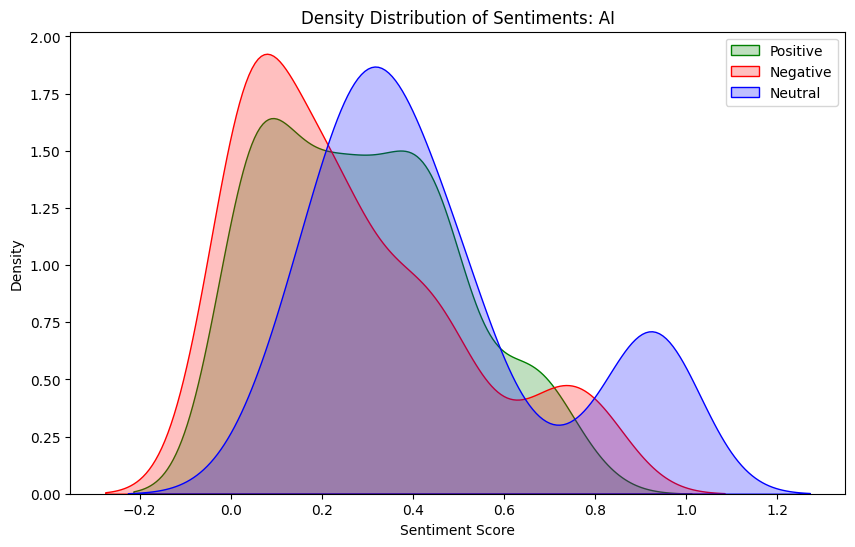

df is currently:       Q_subcat     Q_category topical  \
0    ambiguous  S_non_factoid     NaN   
3    ambiguous  S_non_factoid     NaN   
6    ambiguous  S_non_factoid     NaN   
9    ambiguous  S_non_factoid     NaN   
12   ambiguous  S_non_factoid    True   
15   ambiguous  S_non_factoid    True   
18   ambiguous  S_non_factoid    True   
21   ambiguous  S_non_factoid     NaN   
24   ambiguous  S_non_factoid     NaN   
27   ambiguous  S_non_factoid     NaN   
30   ambiguous  S_non_factoid     NaN   
33   ambiguous  S_non_factoid    True   
36   ambiguous  S_non_factoid    True   
39   ambiguous  S_non_factoid    True   
42   ambiguous  S_non_factoid     NaN   
45   ambiguous  S_non_factoid     NaN   
48   ambiguous  S_non_factoid     NaN   
51   ambiguous  S_non_factoid     NaN   
54   ambiguous  S_non_factoid    True   
57   ambiguous  S_non_factoid    True   
60   ambiguous  S_non_factoid    True   
63   ambiguous  S_non_factoid     NaN   
66   ambiguous  S_non_factoid     NaN   

/tmp/ipykernel_523909/1086102555.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_523909/1086102555.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_523909/1086102555.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


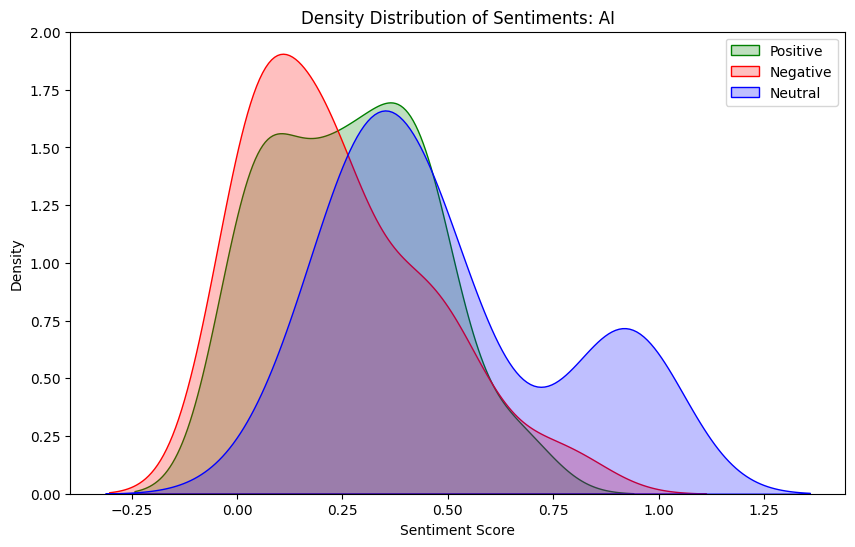

df is currently:      Q_subcat     Q_category topical  \
1    positive  S_non_factoid     NaN   
4    positive  S_non_factoid     NaN   
7    positive  S_non_factoid     NaN   
10   positive  S_non_factoid     NaN   
13   positive  S_non_factoid    True   
16   positive  S_non_factoid    True   
19   positive  S_non_factoid    True   
22   positive  S_non_factoid     NaN   
25   positive  S_non_factoid     NaN   
28   positive  S_non_factoid     NaN   
31   positive  S_non_factoid     NaN   
34   positive  S_non_factoid    True   
37   positive  S_non_factoid    True   
40   positive  S_non_factoid    True   
43   positive  S_non_factoid     NaN   
46   positive  S_non_factoid     NaN   
49   positive  S_non_factoid     NaN   
52   positive  S_non_factoid     NaN   
55   positive  S_non_factoid    True   
58   positive  S_non_factoid    True   
61   positive  S_non_factoid    True   
64   positive  S_non_factoid     NaN   
67   positive  S_non_factoid     NaN   
70   positive  S_non_fa

/tmp/ipykernel_523909/1086102555.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_523909/1086102555.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_523909/1086102555.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


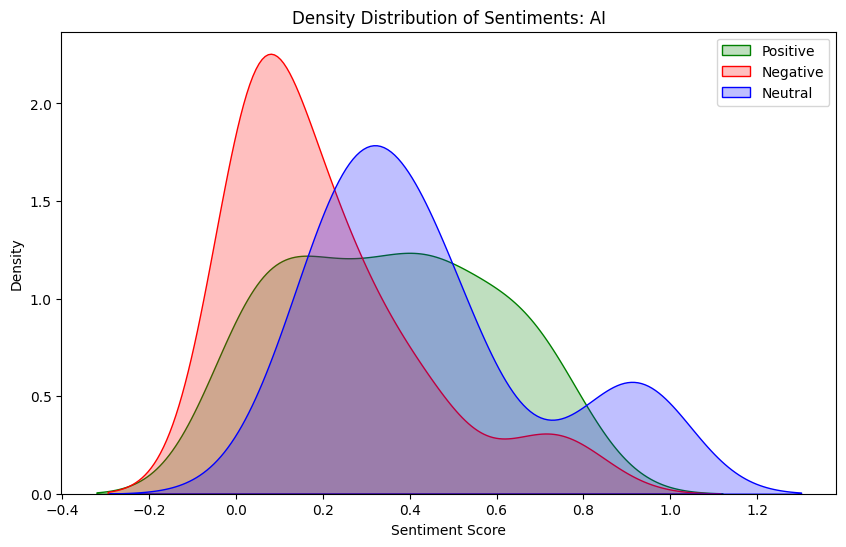

df is currently:      Q_subcat     Q_category topical  \
2    negative  S_non_factoid     NaN   
5    negative  S_non_factoid     NaN   
8    negative  S_non_factoid     NaN   
11   negative  S_non_factoid     NaN   
14   negative  S_non_factoid    True   
17   negative  S_non_factoid    True   
20   negative  S_non_factoid    True   
23   negative  S_non_factoid     NaN   
26   negative  S_non_factoid     NaN   
29   negative  S_non_factoid     NaN   
32   negative  S_non_factoid     NaN   
35   negative  S_non_factoid    True   
38   negative  S_non_factoid    True   
41   negative  S_non_factoid    True   
44   negative  S_non_factoid     NaN   
47   negative  S_non_factoid     NaN   
50   negative  S_non_factoid     NaN   
53   negative  S_non_factoid     NaN   
56   negative  S_non_factoid    True   
59   negative  S_non_factoid    True   
62   negative  S_non_factoid    True   
65   negative  S_non_factoid     NaN   
68   negative  S_non_factoid     NaN   
71   negative  S_non_fa

/tmp/ipykernel_523909/1086102555.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_523909/1086102555.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_523909/1086102555.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


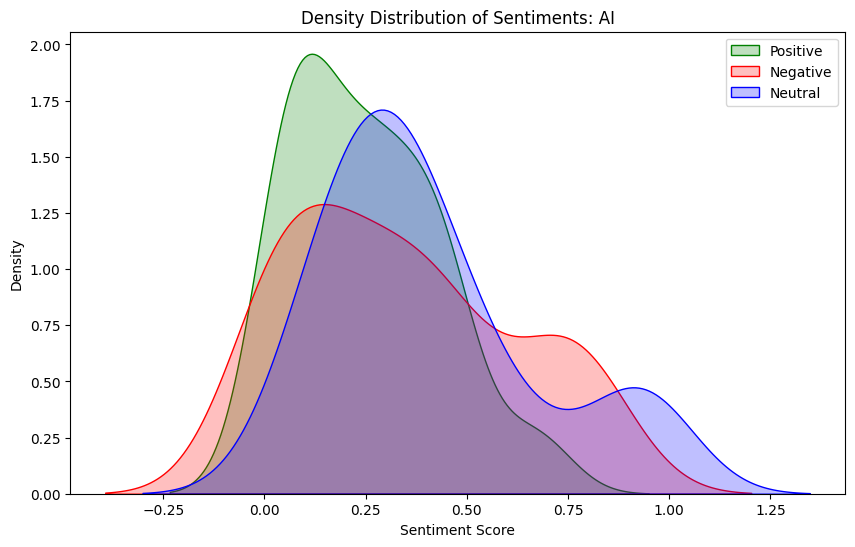

In [12]:

# Assuming absa_model and absa_tokenizer are defined and loaded

import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = merged_df_dropped[f'{aspect}_POS'],
                               neg_list = merged_df_dropped[f'{aspect}_NEG'],
                               neu_list = merged_df_dropped[f'{aspect}_NEU'])  
                               
# Plot for each question type
ambi_questions = merged_df_dropped[merged_df_dropped['Q_subcat'].str.contains('ambiguous', na=False)]
pos_questions = merged_df_dropped[merged_df_dropped['Q_subcat'].str.contains('positive', na=False)]
neg_questions = merged_df_dropped[merged_df_dropped['Q_subcat'].str.contains('negative', na=False)]

for df_ in [ambi_questions, pos_questions, neg_questions]:
    for aspect in aspects:
        print(f"df is currently: {df_}")
        plot_density_distributions(pos_list = df_[f'{aspect}_POS'],
                                neg_list = df_[f'{aspect}_NEG'],
                                neu_list = df_[f'{aspect}_NEU'])  

# Plots grouped on sentiment, distributions for question type

/tmp/ipykernel_523909/1346758679.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
/tmp/ipykernel_523909/1346758679.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
/tmp/ipykernel_523909/1346758679.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_df, shade=True, color="red", label="Negative")


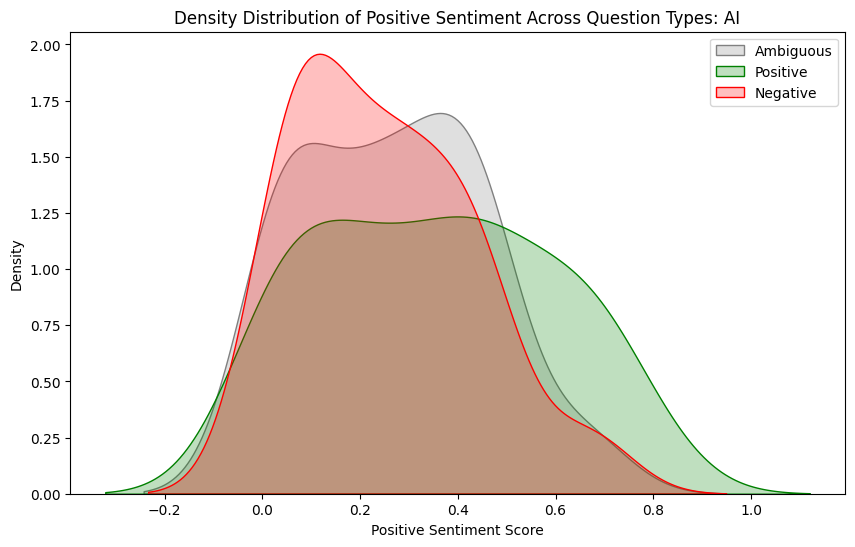

/tmp/ipykernel_523909/1346758679.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
/tmp/ipykernel_523909/1346758679.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
/tmp/ipykernel_523909/1346758679.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_df, shade=True, color="red", label="Negative")


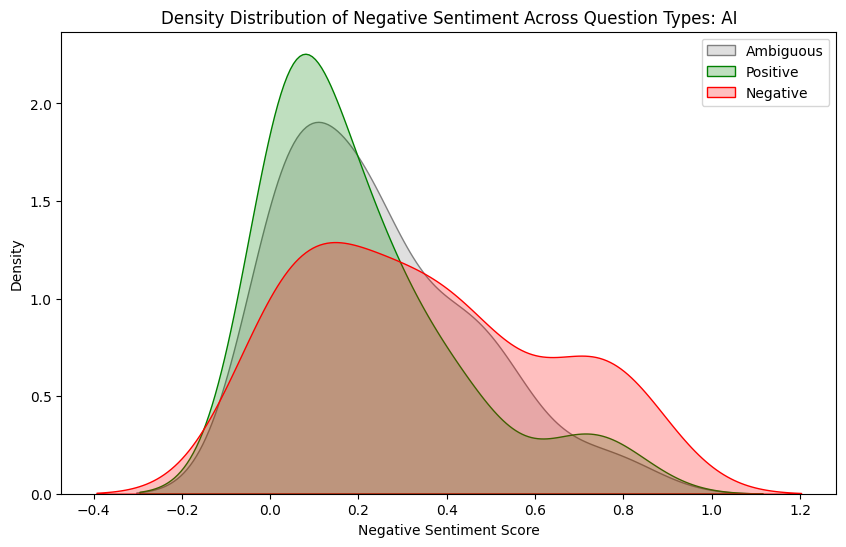

/tmp/ipykernel_523909/1346758679.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
/tmp/ipykernel_523909/1346758679.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
/tmp/ipykernel_523909/1346758679.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_df, shade=True, color="red", label="Negative")


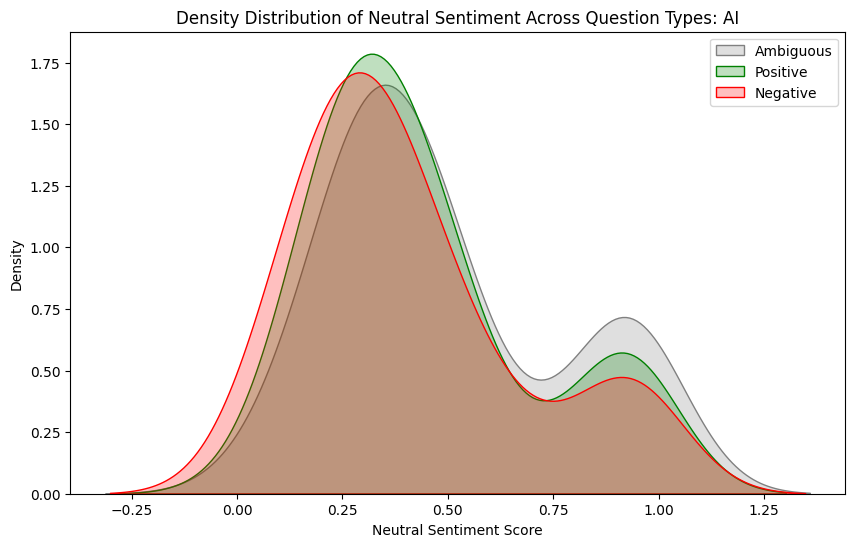

In [13]:
# The other way
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions_by_question_type(sentiment, ambi_df, pos_df, neg_df, aspect):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
    sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
    sns.kdeplot(neg_df, shade=True, color="red", label="Negative")

    plt.title(f"Density Distribution of {sentiment.capitalize()} Sentiment Across Question Types: {aspect}")
    plt.xlabel(f"{sentiment.capitalize()} Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

aspects = ['AI']

# Assuming merged_df_dropped and aspects are defined
for aspect in aspects:
    # Filter DataFrames based on question type
    ambi_questions = merged_df_dropped[merged_df_dropped['Q_subcat'].str.contains('ambiguous', na=False)]
    pos_questions = merged_df_dropped[merged_df_dropped['Q_subcat'].str.contains('positive', na=False)]
    neg_questions = merged_df_dropped[merged_df_dropped['Q_subcat'].str.contains('negative', na=False)]

    # Plot for each sentiment
    plot_density_distributions_by_question_type('positive', ambi_questions[f'{aspect}_POS'], 
                                                pos_questions[f'{aspect}_POS'], neg_questions[f'{aspect}_POS'], aspect)
    plot_density_distributions_by_question_type('negative', ambi_questions[f'{aspect}_NEG'], 
                                                pos_questions[f'{aspect}_NEG'], neg_questions[f'{aspect}_NEG'], aspect)
    plot_density_distributions_by_question_type('neutral', ambi_questions[f'{aspect}_NEU'], 
                                                pos_questions[f'{aspect}_NEU'], neg_questions[f'{aspect}_NEU'], aspect)


# Looking at only topical


/tmp/ipykernel_523909/1346758679.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
/tmp/ipykernel_523909/1346758679.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
/tmp/ipykernel_523909/1346758679.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_df, shade=True, color="red", label="Negative")


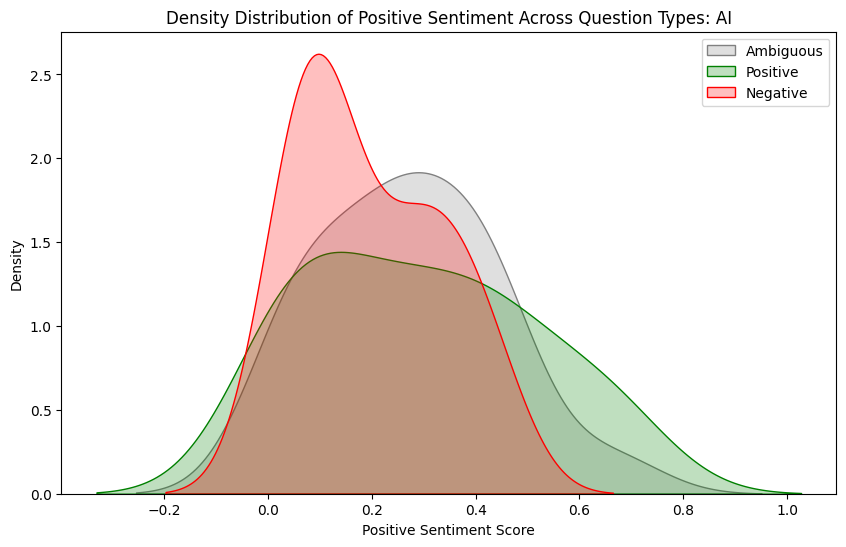

/tmp/ipykernel_523909/1346758679.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
/tmp/ipykernel_523909/1346758679.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
/tmp/ipykernel_523909/1346758679.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_df, shade=True, color="red", label="Negative")


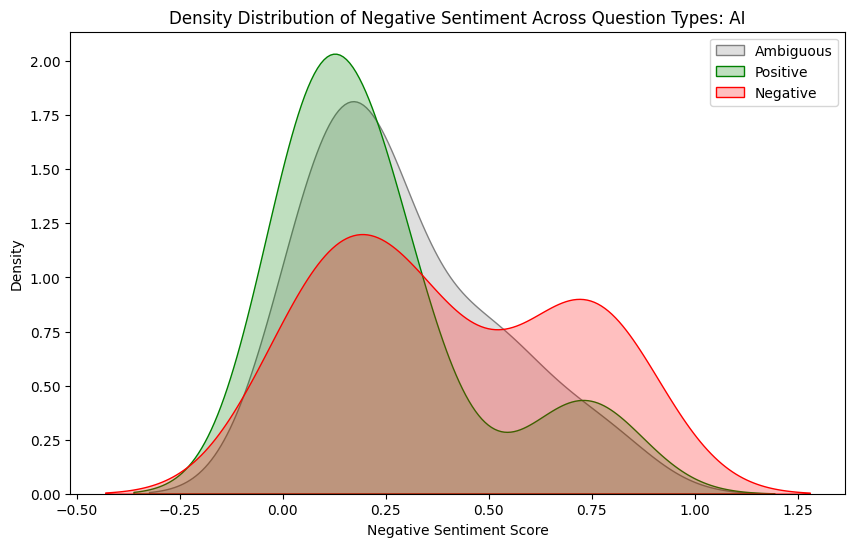

/tmp/ipykernel_523909/1346758679.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambi_df, shade=True, color="grey", label="Ambiguous")
/tmp/ipykernel_523909/1346758679.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_df, shade=True, color="green", label="Positive")
/tmp/ipykernel_523909/1346758679.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_df, shade=True, color="red", label="Negative")


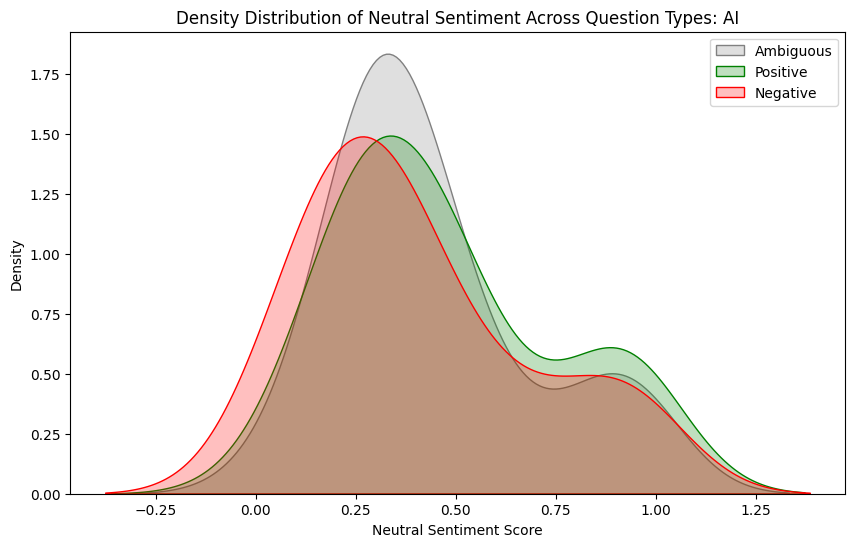

In [18]:
merged_df_dropped_topicalonly = merged_df_dropped[merged_df_dropped['topical'] == True]
merged_df_dropped_non_topical = merged_df_dropped[merged_df_dropped['topical'] != True]

# Assuming merged_df_dropped and aspects are defined
for aspect in aspects:
    # Filter DataFrames based on question type
    ambi_questions = merged_df_dropped_non_topical[merged_df_dropped_non_topical['Q_subcat'].str.contains('ambiguous', na=False)]
    pos_questions = merged_df_dropped_non_topical[merged_df_dropped_non_topical['Q_subcat'].str.contains('positive', na=False)]
    neg_questions = merged_df_dropped_non_topical[merged_df_dropped_non_topical['Q_subcat'].str.contains('negative', na=False)]

    # Plot for each sentiment
    plot_density_distributions_by_question_type('positive', ambi_questions[f'{aspect}_POS'], 
                                                pos_questions[f'{aspect}_POS'], neg_questions[f'{aspect}_POS'], aspect)
    plot_density_distributions_by_question_type('negative', ambi_questions[f'{aspect}_NEG'], 
                                                pos_questions[f'{aspect}_NEG'], neg_questions[f'{aspect}_NEG'], aspect)
    plot_density_distributions_by_question_type('neutral', ambi_questions[f'{aspect}_NEU'], 
                                                pos_questions[f'{aspect}_NEU'], neg_questions[f'{aspect}_NEU'], aspect)


In [20]:
merged_df_dropped.to_csv(f"{path_to_root}/data/prelim_results/ABSA/balanced_tryout0.csv")